# 🏥 Breast Cancer Diagnosis Benchmark
### **A Comparative Analysis of 8 Machine Learning Algorithms**
**Author:** Ashkan Ghorbani  
**Date:** February 2026  
**Repository:** [github.com/ashkanGhr/breast-cancer-diagnosis-benchmark](https://github.com/ashkanGhr/breast-cancer-diagnosis-benchmark)

---
**Project Overview:** This notebook implements a systematic benchmark of Linear, Tree-based, and Ensemble models (including AdaBoost and XGBoost) to predict breast cancer malignancy. It features a robust **Scikit-Learn Pipeline** with **SMOTE** for class imbalance, automated feature selection, and hyperparameter tuning optimized for **Recall**.

In [1]:
# Dataset
from sklearn.datasets import load_breast_cancer

# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from matplotlib.cbook import boxplot_stats
import plotly.express as ex
from imblearn.over_sampling import SMOTE

# Machine learning
from sklearn.experimental import enable_iterative_imputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso, lasso_path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, cross_validate, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, confusion_matrix, RocCurveDisplay, roc_auc_score,recall_score,precision_score, classification_report, roc_curve, auc
import joblib
from xgboost import XGBClassifier
#from skopt import BayesSearchCV, space, plots
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif, mutual_info_classif,SelectFdr, SelectKBest, SelectPercentile, SelectFpr, SelectFwe, VarianceThreshold, SelectFromModel
import statsmodels.api as sm

# Google drive
#from google.colab import drive
#drive.mount('/gdrive')



# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the datase
data = load_breast_cancer(as_frame=True)
df = data.frame

In [3]:
df, df_t = train_test_split(df, test_size=0.15, stratify=df['target'], random_state=42)

In [4]:
# Define X and Y
x = df.drop('target', axis=1)
y = df['target']

x_t = df_t.drop('target', axis=1)
y_t = df_t['target']

# Outlier Detection & Removal (Train Set Only) — Isolation Forest

This code cell performs **outlier detection and removal** on the **training set only** using **Isolation Forest**, based on the variables used in this notebook:

- `x`   → training features  
- `y`   → training labels  
- `x_t` → test features  
- `y_t` → test labels  

It is designed to plug into your existing pipeline without changing the overall workflow.

---

## ✅ Why this method works well for this dataset

This Breast Cancer dataset (your feature matrix `x`) is:

- **tabular** and **numeric** (typical clinical / radiomics-style features)
- potentially contains **noisy / extreme samples** (measurement variability, segmentation noise, acquisition differences, etc.)
- sensitive to **outlier influence**, especially for models like KNN, SVC, Logistic Regression, and even tree ensembles

**Isolation Forest** works well here because it:

- does **not assume normality** (unlike z-score methods)
- detects outliers by how easily a point gets **isolated** in random trees
- handles **multivariate outliers** (outliers in combinations of features, not just one column)

---

## ✅ Key idea (to avoid data leakage)

Outlier detection is fitted **only on the training set**:

- `iso.fit(x)` is run only on `x`
- Outliers are removed only from `x` and `y`
- The test set (`x_t`, `y_t`) is **not altered**

This avoids leaking information from the test set into training decisions.

---

## 🔧 What the code does step-by-step

1. Converts `x` and `x_t` to pandas DataFrames (safe for indexing).
2. Converts `y` and `y_t` to 1D label vectors (Series).
3. Fits Isolation Forest on the training features `x`.
4. Creates an `inlier_mask` where:
   - `True` = keep sample (inlier)
   - `False` = drop sample (outlier)
5. Filters:
   - `x = x.loc[inlier_mask]`
   - `y = y.loc[inlier_mask]`
6. Resets indices to keep everything aligned for downstream steps.
7. Prints how many rows were removed.

---

## ⚙️ Parameter you can tune

### `contamination`
```python
contamination = 0.05


In [5]:
# ============================================================
# OUTLIER DETECTION + REMOVAL (TRAIN ONLY) — using YOUR vars
# Vars in your notebook: x, x_t, y, y_t
# Place this cell AFTER x/x_t/y/y_t are created,
# and BEFORE scaling / feature-selection / model training.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

# --- ensure pandas objects ---
x   = pd.DataFrame(x).copy()
x_t = pd.DataFrame(x_t).copy()

# y/y_t can be Series, ndarray, or 1-col DataFrame
if isinstance(y, pd.DataFrame):
    y_series = y.iloc[:, 0].copy()
else:
    y_series = pd.Series(np.asarray(y).ravel()).copy()

if isinstance(y_t, pd.DataFrame):
    y_t_series = y_t.iloc[:, 0].copy()
else:
    y_t_series = pd.Series(np.asarray(y_t).ravel()).copy()

# --- Isolation Forest settings ---
# contamination = expected outlier fraction in TRAIN set (tune if needed)
contamination = 0.05
random_state = 42

iso = IsolationForest(
    n_estimators=500,
    contamination=contamination,
    random_state=random_state,
    n_jobs=-1
)

# ✅ Fit ONLY on training features
iso.fit(x)

# 1=inlier, -1=outlier
inlier_mask = (iso.predict(x) == 1)

# --- apply mask to TRAIN ONLY ---
n_before = len(x)
x = x.loc[inlier_mask].copy()
y_series = y_series.loc[inlier_mask].copy()
n_after = len(x)

print("✅ Outlier removal: IsolationForest")
print(f"Train rows before: {n_before}")
print(f"Train rows after : {n_after}")
print(f"Removed outliers : {n_before - n_after} ({(n_before - n_after)/n_before*100:.1f}%)")

# --- put y/y_t back in a consistent format (1-col DataFrame) ---
y   = pd.DataFrame(y_series.reset_index(drop=True), columns=["target"])
y_t = pd.DataFrame(y_t_series.reset_index(drop=True), columns=["target"])

# keep x/x_t clean indices too
x   = x.reset_index(drop=True)
x_t = x_t.reset_index(drop=True)

# After this, continue with your normal pipeline:
# scaling -> train models -> predict -> export to Excel/RTF


✅ Outlier removal: IsolationForest
Train rows before: 483
Train rows after : 458
Removed outliers : 25 (5.2%)


# EDA

In [6]:
# We create a new column 'diagnosis' just for visualization purposes
df['diagnosis'] = df['target'].map({0: 'Malignant', 1: 'Benign'})

In [7]:
# ==========================================
# PART 1: BASIC DATA INSPECTION
# ==========================================

print("--- 1. Data Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n--- 2. Missing Values Check ---")
print(df.isnull().sum().sum())  # Should be 0 for this specific dataset

print("\n--- 3. Statistical Summary ---")
# Transpose (.T) makes it easier to read with 30 columns
display(df.describe().T)

--- 1. Data Shape ---
Rows: 483, Columns: 32

--- 2. Missing Values Check ---
0

--- 3. Statistical Summary ---


,count,mean,std,min,25%,50%,75%,max
mean radius,483.0,14.075014,3.467871,6.981000,11.680000,13.270000,15.720000,28.11000
mean texture,483.0,19.251905,4.362202,9.710000,16.110000,18.820000,21.710000,39.28000
mean perimeter,483.0,91.579586,23.915663,43.790000,74.935000,85.980000,103.650000,188.50000
mean area,483.0,648.748033,341.908962,143.500000,417.950000,542.900000,770.050000,2499.00000
mean smoothness,483.0,0.096109,0.013697,0.062510,0.086475,0.095160,0.105000,0.14470
mean compactness,483.0,0.103204,0.053191,0.019380,0.062730,0.090090,0.130100,0.34540
mean concavity,483.0,0.087946,0.080672,0.000000,0.028010,0.058920,0.131300,0.42680
mean concave points,483.0,0.048133,0.038681,0.000000,0.019685,0.032640,0.073820,0.20120
mean symmetry,483.0,0.180661,0.028040,0.106000,0.161650,0.178000,0.195500,0.30400
mean fractal dimension,483.0,0.062729,0.007151,0.049960,0.057585,0.061290,0.066250,0.09744


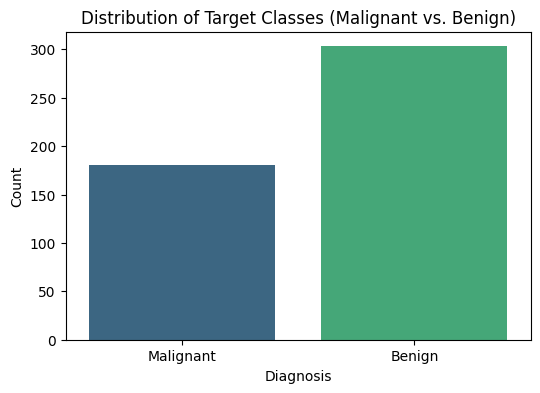

In [8]:
# ==========================================
# PART 2: TARGET DISTRIBUTION (Class Balance)
# ==========================================

plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Distribution of Target Classes (Malignant vs. Benign)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Oversampling the Minority Class with SMOTE (Training Set Only)

This code applies **SMOTE (Synthetic Minority Over-sampling Technique)** to the **training dataset** to handle **class imbalance** by generating synthetic samples for the minority class.

---

## Why SMOTE?

When your dataset is imbalanced (e.g., far fewer positive cancer cases than negative cases), many classifiers can become biased toward the majority class. This often causes:

- low sensitivity/recall for the minority class  
- misleadingly high accuracy  
- poor detection of the rare class (often the clinically important one)

SMOTE helps by **balancing the class distribution** in the training set.

---

## What the code does

### 1) Define the SMOTE sampler

The sampler is initialized as:

- `sampling_strategy='auto'`: oversample the minority class until it matches the majority class (default balancing behavior)
- `random_state=42`: makes the resampling reproducible

---

### 2) Apply SMOTE to the training data only

The key operation is:

- `x_train_smote, y_train_smote = smote.fit_resample(x, y)`

✅ SMOTE is fitted and applied **only on training data** (`x`, `y`).

This is important to avoid **data leakage**:
- do **not** apply SMOTE to the test set, because it would change the true distribution and can produce overly optimistic evaluation.

SMOTE generates synthetic minority-class samples by interpolating between existing minority samples and their nearest neighbors in feature space.

---

### 3) Verify the results

The printed outputs confirm the effect of SMOTE:

- class distribution before SMOTE (`y.value_counts()`)
- class distribution after SMOTE (`y_train_smote.value_counts()`)
- shape before and after (`x.shape` vs. `x_train_smote.shape`)

✅ After SMOTE, you should see the minority class count increased (often equal to the majority class), and the training dataset will have more rows.

---

## Outputs

- `x_train_smote`: balanced training features (more rows than the original training set)
- `y_train_smote`: balanced training labels

Use these SMOTE outputs for model training instead of the original `x`, `y`.

---

## Best practices / important notes

- Apply SMOTE **only after train/test split**, and only to the training set.
- If you use feature scaling, a common workflow is:
  1) fit scaler on `x_train`
  2) transform `x_train`
  3) apply SMOTE to the transformed `x_train`
  4) transform `x_test` using the same scaler (no SMOTE)

- If results seem unstable, you can tune SMOTE parameters like `k_neighbors` depending on dataset size and minority-class density.

---


In [9]:
# Defining SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit SMOTE *only* on the training data
x_train_smote, y_train_smote = smote.fit_resample(x, y)

# 4. Verification
print("Original Class Distribution:\n", y.value_counts())
print("\nResampled Class Distribution:\n", y_train_smote.value_counts())
print(f"\nOriginal Train shape: {x.shape}")
print(f"New Train shape (SMOTE): {x_train_smote.shape}")

Original Class Distribution:
 target
1         298
0         160
Name: count, dtype: int64

Resampled Class Distribution:
 target
0         298
1         298
Name: count, dtype: int64

Original Train shape: (458, 30)
New Train shape (SMOTE): (596, 30)


In [10]:
# Overwrite x and y with the SMOTE-resampled data for subsequent analysis
x = x_train_smote
y = y_train_smote

# **Variance threshold**

# Low-Variance Feature Removal Using `VarianceThreshold`

This section explains a feature-selection step that removes **low-variance features** from your dataset. Low-variance features are those that **barely change across samples**, meaning they often behave like constants and usually contribute little (or nothing) to model performance.

In your notebook, this step is applied using:

- `x` → feature DataFrame  
- `y` → label vector  
and the filtered feature set is saved back into `X`.

---

## Why remove low-variance features?

A feature with extremely small variance means:

- its values are almost the same for nearly all samples
- it provides very little information to distinguish classes
- it can add noise and increase dimensionality without improving prediction

Removing such features can:

- reduce overfitting risk (especially in small datasets)
- improve numerical stability for models like Logistic Regression / SVC
- reduce model training time
- make feature selection and correlation analysis cleaner

---

## What this method does (high-level)

1. Takes the training feature set `x` and assigns it to `X`.
2. Applies `VarianceThreshold(threshold=0.01)`:
   - any feature with variance **below 0.01** is removed
3. Extracts the list of **selected (kept) feature names**
4. Rebuilds `X` as a clean DataFrame containing only the remaining features
5. Computes the list of removed features (`low_var_cols`)
6. Drops the same low-variance columns from:
   - `df` (if present)
   - `df_t` (if present)

---

## Step-by-step explanation

### 1) Define feature and label variables

The code starts with:

- `X = x`
- `Y = y`

This sets up `X` as the feature DataFrame used for variance filtering and `Y` as the label vector.

> Although `VarianceThreshold` does not strictly require `Y`, your code uses `.fit(X, Y)` for consistency.

---

### 2) Apply variance threshold filtering

The core operation is:

- `VarianceThreshold(threshold=0.01)`

This removes any feature where:

- `Var(feature) < 0.01`

✅ Meaning: the feature does not vary enough across samples to be useful.

> The threshold value `0.01` is tunable.  
> If you want more aggressive removal, increase it (e.g., 0.02).  
> If you want to be more conservative, reduce it (e.g., 0.001).

---

### 3) Identify which features were kept

After fitting the selector, the code extracts a boolean mask:

- `selected_features_mask = selector0.get_support()`

This mask has one element per column in `X`:
- `True` → keep the feature
- `False` → remove the feature

Then it converts the mask into actual column names:

- `selected_features = X.columns[selected_features_mask]`

✅ This is the list of features that survived the variance filter.

---

### 4) Create a clean reduced dataset with correct column names

The selector transforms `X` into a numpy array, so the code reconstructs a DataFrame:

- `X = pd.DataFrame(selector0.transform(X), columns=selected_features)`

This ensures:
- the reduced dataset remains a pandas DataFrame
- column names stay correct and readable

Finally it prints:

- `print(X.shape)`

✅ This verifies the number of remaining features.

---

## Keeping other dataframes consistent (`df` and `df_t`)

Your notebook also maintains dataset-wide tables like `df` and `df_t` that may contain:
- features
- other metadata columns
- sometimes a `target` column

To keep everything aligned, the code:

### 1) Computes which columns were removed
```python
low_var_cols = [c for c in x.columns if c not in selected_features]
These are the exact features that failed the variance threshold.

## Drops them from `df` and `df_t` if they exist

- If `df` exists, low-variance columns are removed from it.
- If `df_t` exists, the same columns are removed from it.

This keeps train/test feature columns consistent across all tables and prevents mismatches later.

---

## Best practices / important notes

### Run on training data only (avoid leakage)

Variance filtering should be determined from the **training features**.  
Once the columns to remove are identified, you apply the same removal to test data (`df_t` or `x_t`).

### Also apply it to `x_t` directly if you use `x_t`

If your modeling later uses `x_t` separately from `df_t`, drop the same columns:

```python
x_t = x_t.drop(columns=low_var_cols, errors="ignore")


In [11]:

### This peace of code is focused on removal of features which have low variance compared to other features
### Features with low variance does not contribute much on modeling performance, because they are nearly constant over the samples


from sklearn.feature_selection import VarianceThreshold

X=x 
Y=y 

# Variance Threshold
selector0 = VarianceThreshold(threshold=0.01).fit(X, Y) # This will remove features with variance below 0.01

# Extracting the index of selected columns
selected_features_mask = selector0.get_support() # Extracting the mask of selected features

# Extracting the name of remained columns of X
selected_features = X.columns[selected_features_mask] # Extracting the names of the features that have been selected based on variance threshold

# Converting the output to a DataFrame with the correct column names
X = pd.DataFrame(selector0.transform(X), columns=selected_features) # Updating X using the selected features


print(X.shape) # Printing the shape of X to verify its dimensions

# --- Append-only: also drop the same low-variance features from your dataframe(s) ---

# Columns removed by the variance filter (computed from the original feature set `x`)
low_var_cols = [c for c in x.columns if c not in selected_features]

# Update df if it exists (keeps 'target' intact)
if 'df' in globals():
    df.drop(columns=[c for c in low_var_cols if c in df.columns], inplace=True, errors='ignore')
    print(f"Removed {len(low_var_cols)} low-variance features from df.")
    print("df shape:", df.shape)
else:
    print("Note: df not found; skipped updating df.")


# Update df_t if it exists (keeps 'target' intact)
if 'df_t' in globals():
    df_t.drop(columns=[c for c in low_var_cols if c in df_t.columns], inplace=True, errors='ignore')
    print(f"Removed {len(low_var_cols)} low-variance features from df_t.")
    print("df_t shape:", df_t.shape)
else:
    print("Note: df_t not found; skipped updating df_t.")


(596, 14)
Removed 16 low-variance features from df.
df shape: (483, 16)
Removed 16 low-variance features from df_t.
df_t shape: (86, 15)


# Correlated Feature Removal Using Pearson Correlation + Univariate ROC AUC (Tie-Breaker)

This section explains a feature-selection routine that removes **redundant (highly correlated)** features from a training dataset while keeping the **more predictive** feature in each correlated pair.

The method is designed for **binary classification** problems (like breast cancer detection) where `Y` is the label and `X` contains numeric feature columns.

---

## Why do this?

Many medical / radiomics / engineered datasets contain features that measure very similar signals. This leads to:

- **Multicollinearity** (features convey the same information)
- **Model instability** (small changes in training data can change which feature a model relies on)
- **Overfitting risk** (especially when the number of features is high)
- **Degraded performance** for distance-based models (KNN) and margin-based models (SVC)

Removing redundant features can improve generalization and make the feature set easier to interpret.

---

## What the method does (high-level)

1. Compute a **Pearson correlation matrix** across all features.
2. Identify feature pairs with absolute correlation above a threshold (e.g., `|corr| > 0.8`).
3. For each highly correlated pair, keep only one feature:
   - compute a **univariate ROC AUC score** for each feature (feature vs. target)
   - **drop the feature with the lower AUC**
4. Recompute the correlation matrix on the reduced dataset to confirm redundancy has decreased.

---

## Step-by-step explanation

### 1) Encode the target `Y` for AUC calculation

ROC AUC requires **numeric labels** (0/1). If your labels are strings or categories, they must be encoded.

- `LabelEncoder` converts labels into numeric classes.
- This should be done on the **training label vector**.

✅ Output: `y_encoded` (numeric labels)

---

### 2) Compute the Pearson correlation matrix

Pearson correlation measures **linear relationship strength** between two variables:

- `corr = +1` → perfectly positively correlated
- `corr = -1` → perfectly negatively correlated
- `corr ≈ 0` → no linear relationship

The correlation matrix is computed across all features in `X`.

A heatmap is then plotted to visually inspect redundancy.

✅ Output: `corr_matrix` and an “Initial Correlation Matrix” heatmap

---

### 3) Compute univariate ROC AUC for each feature (feature quality score)

For each feature column `X[feature]`, the code computes:

- ROC AUC between the feature values and the encoded target `y_encoded`.

This produces a **single-feature predictive strength score**.

#### Handling inverse direction (AUC < 0.5)
Sometimes a feature is predictive but in the reverse direction.  
For example, it might assign higher values to the negative class instead of the positive class.

- If AUC < 0.5, the code uses `1 - AUC`.
- This converts AUC into a “strength” score:
  - AUC 0.2 becomes 0.8 (strong predictor, reversed direction)
  - AUC 0.49 becomes 0.51 (weak predictor)

#### Handling failures
If a feature is constant or causes an AUC calculation error, it gets a neutral score:

- AUC = 0.5

✅ Output: `auc_dict` containing AUC scores for all features

---

### 4) Identify correlated pairs and decide which one to drop

A correlation threshold is set:

- `threshold = 0.8`

For each pair of features `(i, j)`:

- If `abs(corr(i, j)) > threshold`, the pair is considered redundant.

#### Tie-breaker rule (AUC-based)
For each correlated pair:

- Compare `auc_i` vs `auc_j`
- **Drop the feature with lower AUC**
- Keep the feature with higher AUC because it is more predictive of the target

The code prints each decision clearly, for example:

- “Dropping Feature_A (High correlation with Feature_B, Lower AUC: 0.61 < 0.74)”

✅ Output: `features_to_remove` (set of redundant features selected for removal)

---

### 5) Create reduced dataset and re-check correlation

After collecting all redundant features:

- The reduced dataset is created by dropping them from `X`.

Then the correlation matrix is computed again on the reduced dataset, and a second heatmap is shown.

This confirms the correlation structure is less redundant after removal.

✅ Output: `x_reduced` and a “Final Correlation Matrix” heatmap

---

## How to use the result correctly

### Apply the same removal to the test set
To keep train/test aligned, drop the same features from the test set:

- `x_t_reduced = x_t.drop(columns=list(features_to_remove))`

If you don’t do this, your model may train on one set of features and test on another (which breaks evaluation).

---

## Important best practices

### Avoid data leakage
This method should be fitted using **training data only**:
- correlations and AUC scores must be computed on training features and labels
- do **not** compute correlation / AUC using test data

### Choose the correlation threshold thoughtfully
- Lower threshold (e.g., 0.7) → more aggressive removal
- Higher threshold (e.g., 0.9) → more conservative removal

A common default is **0.8**, but tuning it is reasonable depending on dataset size and feature redundancy.

### Univariate AUC is a heuristic
Univariate AUC measures predictive power of a feature **by itself**.
It does not capture feature interactions.  
However, it is a strong and simple tie-breaker for deciding which correlated feature to keep.

---

## When this method is especially useful

This approach is effective when:

- you have many numeric features (radiomics, engineered features, biomarker panels)
- the dataset includes repeated or derived measurements that cause high correlation
- you use models sensitive to redundancy (KNN, SVC, logistic regression)
- you want a transparent and explainable feature reduction method

---

## Summary

This method reduces feature redundancy by:

- detecting highly correlated feature pairs via **Pearson correlation**
- keeping the feature with greater predictive strength using **univariate ROC AUC**
- producing a reduced dataset (`x_reduced`) that is more stable and less redundant

It is a clean and explainable way to shrink feature space while preserving predictive information.


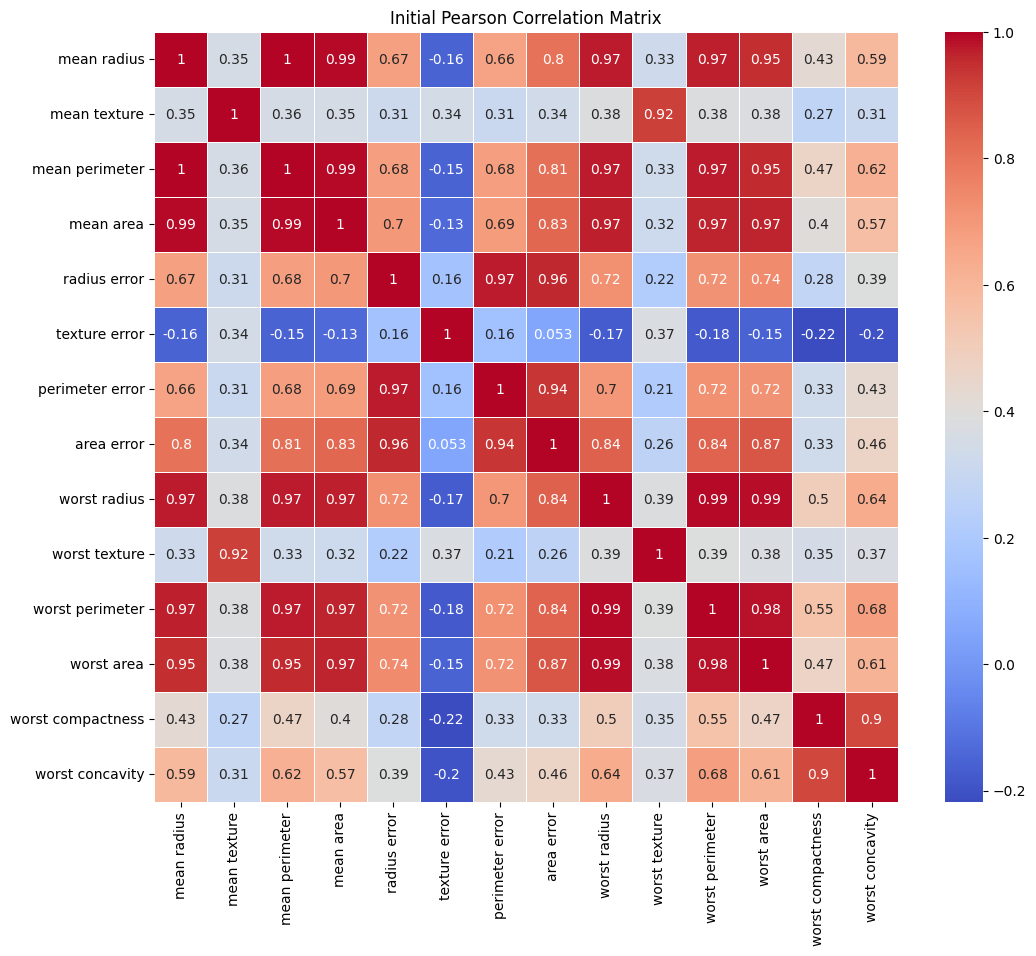

Univariate ROC AUC scores per feature:
mean radius: 0.9437
mean texture: 0.7793
mean perimeter: 0.9529
mean area: 0.9445
radius error: 0.8684
texture error: 0.5124
perimeter error: 0.8726
area error: 0.9280
worst radius: 0.9758
worst texture: 0.7901
worst perimeter: 0.9798
worst area: 0.9759
worst compactness: 0.8908
worst concavity: 0.9360
Dropping 'mean radius' (High correlation with 'mean perimeter', Lower AUC: 0.944 < 0.953)
Dropping 'mean area' (High correlation with 'mean perimeter', Lower AUC: 0.944 < 0.953)
Dropping 'radius error' (High correlation with 'perimeter error', Lower AUC: 0.868 < 0.873)
Dropping 'area error' (High correlation with 'mean perimeter', Lower AUC: 0.928 < 0.953)
Dropping 'mean perimeter' (High correlation with 'worst radius', Lower AUC: 0.953 < 0.976)
Dropping 'mean texture' (High correlation with 'worst texture', Lower AUC: 0.779 < 0.790)
Dropping 'worst radius' (High correlation with 'worst perimeter', Lower AUC: 0.976 < 0.980)
Dropping 'worst area' (Hi

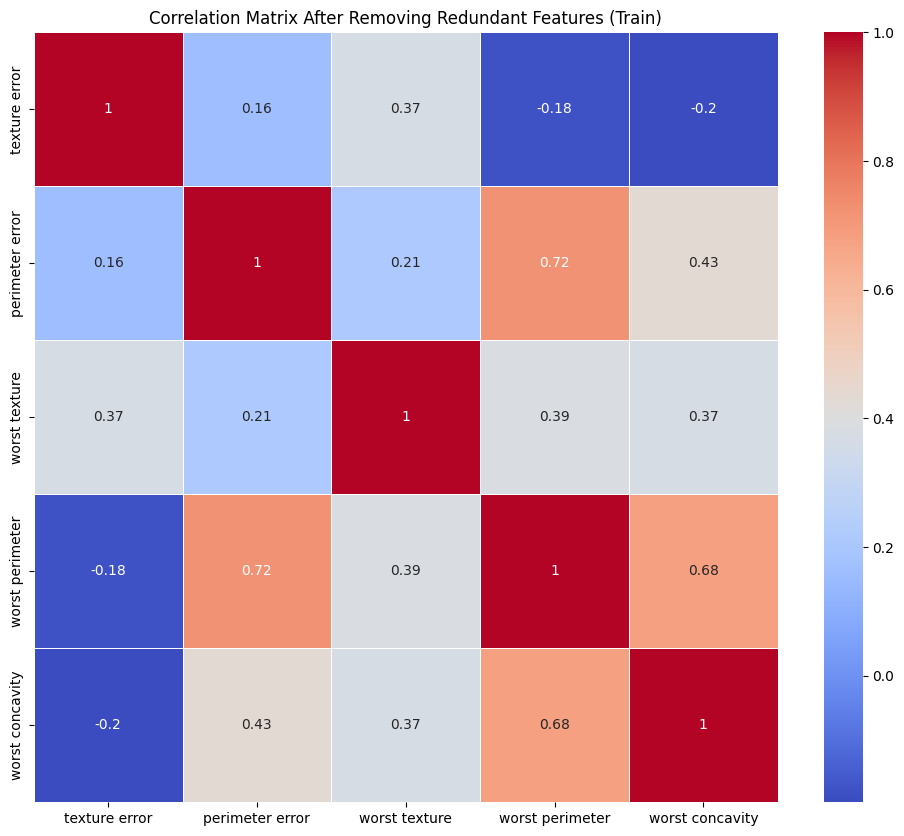

,texture error,perimeter error,worst texture,worst perimeter,worst concavity
0,1.256,7.673,26.40,166.10,0.41070
1,1.532,1.199,28.46,84.53,0.03619
2,1.354,1.994,28.39,108.10,0.37790
3,1.492,2.888,33.17,100.20,0.13260
4,1.045,1.649,20.14,87.64,0.15140


,texture error,perimeter error,worst texture,worst perimeter,worst concavity
0,0.9622,3.591,27.78,118.60,0.4589
1,1.2320,3.270,30.38,129.80,0.3597
2,1.4100,7.337,32.33,155.30,0.4890
3,1.0930,3.014,16.38,69.05,0.2099
4,1.1990,7.158,36.27,178.60,0.4251


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

# ==========================================
# Step 1: Encode Targets for AUC Calculation
# ==========================================
# ROC AUC requires numeric labels. We encode the target variable Y.
label_encoder = preprocessing.LabelEncoder()
y_encoded = Y

# ==========================================
# Step 2: Calculate Correlation Matrix
# ==========================================
# We calculate the Pearson correlation coefficient to identify linear relationships.
# High absolute correlation indicates redundant features.
corr_matrix = X.corr(method='pearson') # Ensure X is x_train

# Visualization: Initial Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Initial Pearson Correlation Matrix")
plt.show()

# ==========================================
# Step 3: Calculate Univariate ROC AUC Scores
# ==========================================
# This score acts as a "quality metric" for each feature.
# We will use this to decide which feature to KEEP when two features are highly correlated.
auc_dict = {}
for feature in X.columns:
    try:
        # Calculate AUC for the single feature against the target
        auc = roc_auc_score(y_encoded, X[feature])
        
        # Handle Inverse Correlations:
        # If AUC < 0.5, it means the feature is negatively correlated with the target.
        # We invert it (1 - AUC) because we care about the "strength" of prediction, not the direction.
        # e.g., AUC of 0.2 is as powerful as 0.8.
        if auc < 0.5:
            auc = 1 - auc
        auc_dict[feature] = auc
    except Exception as e:
        # Fallback: If calculation fails (e.g., constant feature), assign a neutral score.
        auc_dict[feature] = 0.5

print("Univariate ROC AUC scores per feature:")
for feat, auc in auc_dict.items():
    print(f"{feat}: {auc:.4f}")

# ==========================================
# Step 4: Remove Correlated Features based on AUC
# ==========================================
threshold = 0.8  # Threshold for high correlation (can be adjusted)
features = X.columns.tolist()
features_to_remove = set()

# Iterate through the correlation matrix to find pairs
for i in range(len(features)):
    for j in range(i):
        # Optimization: Skip if one of the features is already marked for removal
        if features[i] in features_to_remove or features[j] in features_to_remove:
            continue
        
        # Check the absolute correlation value
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            # TIE-BREAKER LOGIC:
            # Compare the AUC scores of the two correlated features.
            auc_i = auc_dict[features[i]]
            auc_j = auc_dict[features[j]]
            
            # Remove the feature with the LOWER AUC score (less predictive power)
            if auc_i < auc_j:
                features_to_remove.add(features[i])
                print(f"Dropping '{features[i]}' (High correlation with '{features[j]}', Lower AUC: {auc_i:.3f} < {auc_j:.3f})")
            else:
                features_to_remove.add(features[j])
                print(f"Dropping '{features[j]}' (High correlation with '{features[i]}', Lower AUC: {auc_j:.3f} < {auc_i:.3f})")

print(f"\nTotal features to remove: {len(features_to_remove)}")
print("Features removed:", features_to_remove)

# ==========================================
# Step 5: Create Reduced Train/Test Datasets & Re-evaluate
# ==========================================
# Apply the same feature drop list to BOTH train and test so columns stay aligned.

cols_to_drop = list(features_to_remove)

# Reduced training set
x_reduced = X.drop(columns=cols_to_drop, errors="ignore")

# Reduced test set (make sure you have x_t defined as your test features)
x_t_reduced = x_t.drop(columns=cols_to_drop, errors="ignore")

# ---- Safety: ensure same column order and same columns ----
# If your test set is missing any columns, add them as zeros (rare, but safe)
missing_in_test = set(x_reduced.columns) - set(x_t_reduced.columns)
for c in missing_in_test:
    x_t_reduced[c] = 0.0

# If your test has extra columns not in train, remove them
extra_in_test = set(x_t_reduced.columns) - set(x_reduced.columns)
if extra_in_test:
    x_t_reduced = x_t_reduced.drop(columns=list(extra_in_test))

# Align column order exactly
x_t_reduced = x_t_reduced[x_reduced.columns]

print("Final reduced train shape:", x_reduced.shape)
print("Final reduced test shape :", x_t_reduced.shape)

# Optional: verify correlation reduction on training set only
corr_matrix_reduced = x_reduced.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_reduced, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix After Removing Redundant Features (Train)")
plt.show()

display(x_reduced.head())
display(x_t_reduced.head())


In [13]:
df.drop(columns=list(features_to_remove), axis=1, inplace=True)  # Apply the same feature removal to the test dataset


print(f"Correlated features removed: {list(features_to_remove)}") # This will print the list of features that were removed due to high correlation.
print("Final training shape:", df.shape) # Final shape of the training dataset after feature removal

Correlated features removed: ['worst compactness', 'mean radius', 'mean texture', 'mean area', 'area error', 'worst area', 'mean perimeter', 'worst radius', 'radius error']
Final training shape: (483, 7)


In [14]:
df_t.drop(columns=list(features_to_remove), axis=1, inplace=True)  # Apply the same feature removal to the test dataset


print(f"Correlated features removed: {list(features_to_remove)}") # This will print the list of features that were removed due to high correlation.
print("Final training shape:", df_t.shape) # Final shape of the training dataset after feature removal

Correlated features removed: ['worst compactness', 'mean radius', 'mean texture', 'mean area', 'area error', 'worst area', 'mean perimeter', 'worst radius', 'radius error']
Final training shape: (86, 6)


In [15]:
X = x_reduced.copy() # Use the reduced feature set for modeling
X_t = x_t_reduced.copy() # Use the reduced feature set for modeling
Y_t = y_t.copy()

# **Define x and y**

In [16]:
df

,texture error,perimeter error,worst texture,worst perimeter,worst concavity,target,diagnosis
564,1.256,7.673,26.40,166.10,0.41070,0,Malignant
334,1.532,1.199,28.46,84.53,0.03619,1,Benign
448,1.354,1.994,28.39,108.10,0.37790,1,Benign
560,1.492,2.888,33.17,100.20,0.13260,1,Benign
401,1.045,1.649,20.14,87.64,0.15140,1,Benign
...,...,...,...,...,...,...,...
300,1.161,7.237,26.24,171.10,0.61210,0,Malignant
509,1.961,2.937,36.33,117.70,0.59110,0,Malignant
230,0.679,2.153,24.89,133.50,0.50180,0,Malignant
495,1.636,1.596,28.48,103.90,0.17000,1,Benign


In [17]:
X.columns = X.columns.astype(str) # Ensuring that the column names of X are strings

print(X.shape, Y.shape) # Printing the shapes of X and Y to verify their dimensions
print(X_t.shape, Y_t.shape) # Printing the shapes of X_t and Y_t to verify their dimensions
#print(Y)
print(X) # Printing the X DataFrame to verify its contents

(596, 5) (596, 1)
(86, 5) (86, 1)
     texture error  perimeter error  worst texture  worst perimeter  \
0         1.256000         7.673000      26.400000       166.100000   
1         1.532000         1.199000      28.460000        84.530000   
2         1.354000         1.994000      28.390000       108.100000   
3         1.492000         2.888000      33.170000       100.200000   
4         1.045000         1.649000      20.140000        87.640000   
..             ...              ...            ...              ...   
591       0.991030         2.329648      30.916328       130.464116   
592       1.047453         3.240875      26.970934       133.646421   
593       1.348999         2.665636      22.337413       152.090633   
594       0.936238         3.209045      27.798386       142.098598   
595       1.125388         3.270917      33.472906       127.495607   

     worst concavity  
0           0.410700  
1           0.036190  
2           0.377900  
3           0.132600 

# LASSO-Based Feature Selection + (Optional) Radiomics Score Calculation

This section performs **feature scaling**, **LASSO cross-validation**, and **LASSO-based feature selection** to reduce the feature set to the most informative variables. It also includes an optional **Radiomics Score (Rad-score)** computation, which is kept for future use when radiomics features are available.

> **Note:** In the current project, the Radiomics Score may not be meaningful because radiomics features are not present. However, the code is preserved for future datasets where radiomics features exist.

---

## What this pipeline does (overview)

1. **Scale the feature data** (`X` and `X_t`) using `StandardScaler`
2. **Tune the LASSO regularization strength (`alpha`)** via cross-validation (`LassoCV`)
3. **Fit a final LASSO model** using the best `alpha`
4. **Select features with nonzero LASSO coefficients** (`SelectFromModel`)
5. **(Optional)** compute a **Radiomics Score** as a weighted linear combination of selected features
6. Update `X` and `X_t` so that they contain **only the selected features**

---

## Inputs and expected variables

This code assumes the following variables already exist:

- `X`   : training features (pandas DataFrame)
- `X_t` : test features (pandas DataFrame)
- `Y`   : training labels (vector/Series/DataFrame)
- `StandardScaler`, `RobustScaler`, `StratifiedKFold` are available from scikit-learn imports earlier in the notebook

It preserves the original feature names using:

- `cols = X.columns`

---

## Step-by-step explanation

## 1) Feature scaling (train + test)

The code prepares three scalers:
- `StandardScaler()` (used)
- `RobustScaler()` (defined, not used here)
- `QuantileTransformer()` (defined, not used here)

### Scaling strategy used
Only **StandardScaler** is applied:

- Fit scaler on training data: `scaler1.fit_transform(X)`
- Transform test data using the same scaler: `scaler1.transform(X_t)`

This ensures:
- train and test are scaled consistently
- no data leakage from the test set into training scaling

After scaling, `X` and `X_t` are reconstructed as DataFrames using the original column names.

---

## 2) Stratified cross-validation setup

The code uses:

- `StratifiedKFold(n_splits=15, shuffle=True, random_state=42)`

This is helpful because:
- class proportions are preserved in each fold
- results are more stable in imbalanced datasets
- shuffling improves representativeness

---

## 3) LASSO hyperparameter tuning (`LassoCV`)

LASSO requires selecting `alpha` (λ), which controls the strength of regularization.

### Candidate alpha grid
A refined grid is defined:

- `candidate_alphas = np.logspace(-6, 0, 100)`

This covers a range from very small regularization (`1e-6`) to stronger regularization (`1`).

### Cross-validation fit
`LassoCV` is fitted using:
- the candidate alpha grid
- stratified CV folds
- increased `max_iter` and convergence tolerance settings

The code then:
- accesses `mse_path_` (MSE per alpha across folds)
- averages MSE across folds
- selects the alpha with minimum mean MSE

✅ Output:
- `best_alpha` → the chosen LASSO regularization strength

---

## 4) Fit final LASSO model with best alpha

After selecting `best_alpha`, the code fits:

- `lasso = Lasso(alpha=best_alpha, random_state=42).fit(X, Y)`

This produces:
- LASSO coefficients (`lasso.coef_`)
- an intercept (`lasso.intercept_`)

LASSO drives less useful features toward **zero coefficients**, enabling feature selection.

---

## 5) Feature selection using `SelectFromModel`

The code selects features with **nonzero coefficients**:

- `model = SelectFromModel(lasso, prefit=True)`

Then transforms training data:

- `X_lasso_selected = model.transform(X)`

It extracts the selection mask:

- `mask = model.get_support()`

and uses that to get feature names:

- `selected_features = X.columns[mask]`

✅ Output:
- `df_selected_features` → training DataFrame with only selected features
- `selected_features` → list of selected feature names

---

## 6) Optional: Radiomics Score calculation (Rad-score)

This part calculates a linear score:

**Rad-score = (X_selected · coefficients) + intercept**

Where:
- `coefficients` are the nonzero LASSO coefficients
- `X_selected` is the selected feature matrix

Steps:
- collect intercept and nonzero coefficients
- compute weighted sum using `np.dot(...) + intercept`
- store as a DataFrame: `Rad_score_train_df`

> This is typically used in radiomics pipelines where selected radiomics features are combined into a single scalar risk score. If radiomics features are not present, this part can be commented out.

✅ Outputs:
- `Rad_score_train_df` → Radiomics Score for training samples
- `Rad_score_train` → numeric score array

---

## 7) Update final datasets (`X` and `X_t`)

At the end, the code aligns train and test features:

- `X = df_selected_features`
- `X_t = X_t[selected_features]`

This ensures:
- both training and test sets contain the **exact same selected columns**
- downstream modeling uses only the LASSO-selected features

---

## Printed outputs (what you’ll see)

The code prints:
- the first few rows of training Rad-scores
- the number of selected features
- the selected feature names
- the final training data shape
- the chosen `best_alpha`

These prints are meant for verification and documentation.

---

## Best practices / important notes

- Scaling is fit on **training only** and applied to test to avoid leakage.
- `StratifiedKFold` helps ensure robust selection with imbalanced classes.
- LASSO feature selection is best for:
  - high-dimensional feature sets
  - redundant features
  - situations where sparse/compact models are preferred
- Always ensure `X_t` is filtered to the same features (`selected_features`) to prevent shape mismatch at prediction time.

---

## Summary

This block:
- standardizes features using `StandardScaler`
- finds the optimal LASSO regularization via cross-validation
- selects a reduced subset of features using nonzero LASSO coefficients
- optionally computes a Radiomics Score (weighted sum of selected features)
- updates both training and test data to use the selected feature set

It provides a compact, reproducible feature-selection pipeline suitable for future radiomics-based extensions.


In [18]:
# In this project, the Rad score does not have any sense because there is not any radiomics features, but the code will be kept for future use when radiomics features are available.

import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import QuantileTransformer

# --- Scaling ---
cols = X.columns  # original column names
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()

# For the training set:
X_scaled_array = scaler1.fit_transform(X)
X_test_scaled_array = scaler1.transform(X_t)
X = pd.DataFrame(X_scaled_array, index=X.index, columns=cols)
X_t = pd.DataFrame(X_test_scaled_array, index=X_t.index, columns=cols)


n_splits = 15
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)


# --- LASSO ---
# Define a refined grid of candidate alphas (λ values)
candidate_alphas = np.logspace(-6, 0, 100)

# Create the LassoCV object with optimized parameters
lasso_cv = LassoCV(alphas=candidate_alphas,
                     cv=cv,             # 10-fold cross-validation
                     max_iter=10000,    # Increase if convergence is an issue
                     tol=0.001,         # Convergence tolerance
                     random_state=42)   # For reproducibility

# Fit LassoCV on the scaled training data
lasso_cv.fit(X, Y)
mse_path = lasso_cv.mse_path_
mean_mse = np.mean(mse_path, axis=1)
optimal_idx = np.argmin(mean_mse)
best_alpha = lasso_cv.alphas_[optimal_idx]

# Now fit the LASSO model using the best alpha (alpha can be selected manually either)
lasso = Lasso(alpha = best_alpha, random_state=42).fit(X, Y)

# --- Feature Selection using LASSO ---
# Use SelectFromModel to select features with nonzero coefficients
model = SelectFromModel(lasso, prefit=True)
X_lasso_selected = model.transform(X)         # Training data (selected features)


# Extract the boolean mask for selected features and then the column names
mask = model.get_support()
selected_features = X.columns[mask]

# Reassemble the selected features into DataFrames using the preserved column names
df_selected_features = pd.DataFrame(X_lasso_selected, index=X.index, columns=selected_features)


# --- Compute Radiomics Score --- ** USE IT WHEN YOU HAVE RADIOMICS FEATURES, OTHERWISE, YOU CAN COMMENT THIS PART OUT ---
# Get the intercept and the nonzero coefficients corresponding to the selected features
intercept = lasso.intercept_
selected_coefficients = lasso.coef_[mask]  # Only nonzero coefficients

# Calculate weighted sum (Radiomics score) for training and test sets
Rad_score_train = np.dot(df_selected_features.values, selected_coefficients) + intercept

# Convert the Radiomics Scores to DataFrames for readability
Rad_score_train_df = pd.DataFrame(Rad_score_train, index=X.index, columns=['Radiomics Score'])

X = df_selected_features
X_t = X_t[selected_features]  # Ensure test set has the same selected features


# --- Print Results ---
print("\nTraining Set Radiomics Scores:")
print(Rad_score_train_df.head())
print(f'\nNumber of selected features: {df_selected_features.shape[1]}')
print('')
print("Selected feature names:", list(df_selected_features.columns))
print('')
print("Training data shape (original scaled):", X.shape)
print('')
print("Best alpha:", best_alpha)



Training Set Radiomics Scores:
   Radiomics Score
0        -0.106143
1         0.927775
2         0.465963
3         0.621268
4         0.911938

Number of selected features: 5

Selected feature names: ['texture error', 'perimeter error', 'worst texture', 'worst perimeter', 'worst concavity']

Training data shape (original scaled): (596, 5)

Best alpha: 0.00026560877829466864


# AdaBoost model

In [19]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)

X_train = X.values
X_train = scaler2.fit_transform(X_train)
Y_train = y.values
Y_train = Y_train.ravel()


X_test = X_t.values
X_test = scaler2.transform(X_test)
Y_test = y_t.values
Y_test = Y_test.ravel()


# List of parameters for Decision Tree
parameters_DT = ({'random_state':[42], 'criterion':['gini', 'entropy', 'log_loss'], 'splitter':['best', 'random'], 'max_depth':[10, 20, 30, 40], 'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4]})


model_DT = DecisionTreeClassifier()

In [20]:
gs_DT = GridSearchCV(estimator=model_DT, param_grid=parameters_DT, cv=cv, scoring='accuracy')
gs_DT.fit(X_train, Y_train)
print(gs_DT.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'random'}


In [21]:
parameters_ADB = ({'estimator':[DecisionTreeClassifier(random_state=42, criterion=gs_DT.best_params_['criterion'], max_depth=gs_DT.best_params_['max_depth'], min_samples_leaf=gs_DT.best_params_['min_samples_leaf'], min_samples_split=gs_DT.best_params_['min_samples_split'], splitter=gs_DT.best_params_['splitter'])], 'random_state':[42],'n_estimators':[50, 100, 200], 'random_state':[42], 'learning_rate':[0.1, 0.5, 1.0], 'algorithm':['SAMME', 'SAMME.R']})
model_ADB = AdaBoostClassifier(estimator=DecisionTreeClassifier())


gs_ADB = GridSearchCV(estimator=model_ADB, param_grid=parameters_ADB, cv=cv, scoring='accuracy')
gs_ADB.fit(X_train, Y_train)
print(gs_ADB.best_params_)

{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       random_state=42, splitter='random'), 'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 42}


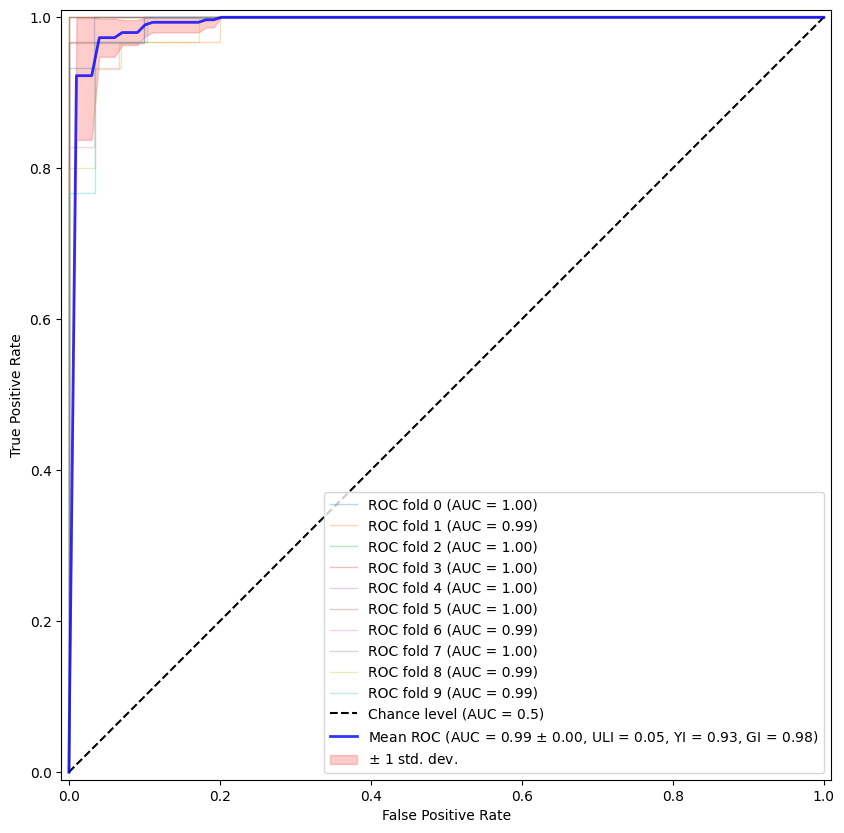

acc: 0.9798657718120806
spec: 0.9832214765100671
pc : 0.9831081081081081
f1 : 0.9797979797979798
sen: 0.9765100671140939


In [22]:
def calc_ULI(Y_test, proba_ADB):
  ulis = []
  fpr, tpr, threshold = roc_curve(Y_test, proba_ADB)
  for i in range(len(fpr)):
    side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
    ulis.append(side)
  return min(ulis)

def ULI_threshold(Y_test, proba_ADB):
  uli_list = []
  uli = 2
  fpr, tpr, threshold = roc_curve(Y_test, proba_ADB)
  for i in range(len(fpr)):
    side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
    uli_list.append(side)
    if side < uli:
      uli = side
  min_uli = min(uli_list)
  min_index = uli_list.index(min_uli)
  return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_ADB):
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_ADB)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)



# Defining lists in order to store confusion matrix values
cm_ADB_TP = []
cm_ADB_FP = []
cm_ADB_TN = []
cm_ADB_FN = []

# ROC related lists and variables
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10, 10))


for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]


    # Initialize and Fit
    model_ADB = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            random_state=42, 
            criterion=gs_DT.best_params_['criterion'], 
            max_depth=gs_DT.best_params_['max_depth'], 
            min_samples_leaf=gs_DT.best_params_['min_samples_leaf'], 
            min_samples_split=gs_DT.best_params_['min_samples_split'], 
            splitter=gs_DT.best_params_['splitter']
        ), 
        random_state=42, 
        learning_rate=gs_ADB.best_params_['learning_rate'], 
        n_estimators=gs_ADB.best_params_['n_estimators'], 
        algorithm=gs_ADB.best_params_['algorithm']
    )
    model_ADB.fit(x_train, y_train)

    y_pred_ADB = model_ADB.predict_proba(x_test)[:,1]

    ULI_1 = calc_ULI(y_test, y_pred_ADB)
    YI_1 = calc_YI(y_test, y_pred_ADB)
    x_roc_1, y_roc_1, thresh_mainADB_b = ULI_threshold(y_test, y_pred_ADB)

    custom_threshold = thresh_mainADB_b
    y_pred_ADB = (y_pred_ADB >= thresh_mainADB_b).astype(int)


    # Calculation of metrics using the total confusion matrix ( sum of all folds all together )
    cm_ADB = confusion_matrix(y_test, y_pred_ADB)

    TN = cm_ADB[0,0]
    cm_ADB_TN.append(TN)
    TN_t = np.sum(cm_ADB_TN)
    FP = cm_ADB[0,1]
    cm_ADB_FP.append(FP)
    FP_t = np.sum(cm_ADB_FP)
    TP = cm_ADB[1,1]
    cm_ADB_TP.append(TP)
    TP_t = np.sum(cm_ADB_TP)
    FN = cm_ADB[1,0]
    cm_ADB_FN.append(FN)
    FN_t = np.sum(cm_ADB_FN)



    # Performance metrics
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)


    # ROC curve and AUC score
    viz = RocCurveDisplay.from_estimator(
        model_ADB,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)


ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",

)
ax.legend(loc="lower right")
plt.show()



print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [23]:
# Predicting the test set

# Probability prediction of LR
proba_ADB = model_ADB.predict_proba(X_test)[:, 1]

# Logical prediction of LR
prob_ADB_SIMPLE = model_ADB.predict(X_test)

print(model_ADB.predict(X_test))
print(model_ADB.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 1 1]
[0.80844762 0.85138761 0.87667217 0.13770507 0.87909085 0.14539265
 0.6436708  0.83458995 0.85628592 0.16872588 0.87392881 0.8237012
 0.12354019 0.21858728 0.74814836 0.15648997 0.13882103 0.12271035
 0.38517857 0.15723939 0.87044353 0.85488178 0.8371225  0.87678767
 0.27538874 0.12740747 0.11934525 0.42231893 0.12120914 0.19051986
 0.8614709  0.11934525 0.37925613 0.13839926 0.83173893 0.84519719
 0.13405243 0.11934525 0.86346477 0.34784702 0.20243499 0.40590625
 0.12145706 0.8280454  0.86233411 0.8783098  0.44708827 0.12236715
 0.88079708 0.15973344 0.12136383 0.83084799 0.87461114 0.23412155
 0.12838341 0.20576613 0.85400067 0.82872492 0.20623491 0.12236715
 0.39732995 0.11934525 0.11934525 0.7928434  0.34209676 0.14244498
 0.1380735  0.12729426 0.12494799 0.17851835 0.14150616 0.24250274
 0.13920081 0.8310396

In [24]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_main1 is being used which is the threshold for train dataset
predictions_ADB = (proba_ADB >= thresh_mainADB_b).astype(int)
print(predictions_ADB)

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1
 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 1 0 1 0 0 1]


spec: 1.0
acc: 0.872093023255814
pc : 1.0
f1 : 0.8865979381443299
AUC: 0.9872685185185185
sen: 0.7962962962962963


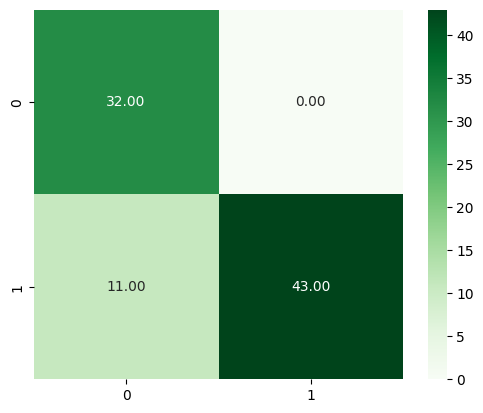

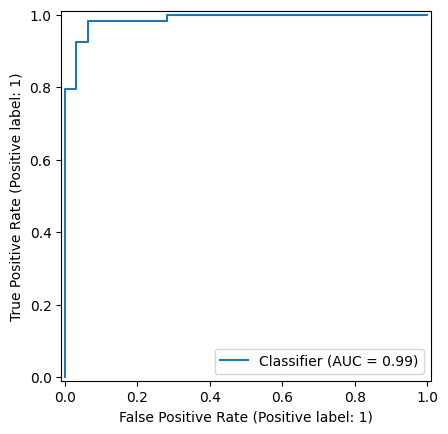

In [77]:
# Metrics for the test --> LR ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_ADB)
acc = accuracy_score(Y_test, predictions_ADB)
pc = precision_score(Y_test, predictions_ADB)
f1 = f1_score(Y_test, predictions_ADB)
AUC = roc_auc_score(Y_test, proba_ADB)
sen = recall_score(Y_test, predictions_ADB)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_ADB)

# LR model

In [26]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()

n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)


# List of parameters for LR
parameters_LR = ({'random_state':[42], 'penalty':['l1', 'l2', 'elasticnet', 'none'], 'C':[0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5], 'solver':['lbfgs', 'liblinear', 'saga'], 'class_weight':['balanced', 'None'], 'fit_intercept':[True, False]})

model_LR = LogisticRegression()

In [27]:
gs_LR = GridSearchCV(estimator=model_LR, param_grid=parameters_LR, cv=cv, scoring='accuracy')
gs_LR.fit(X_train, Y_train)
print(gs_LR.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}


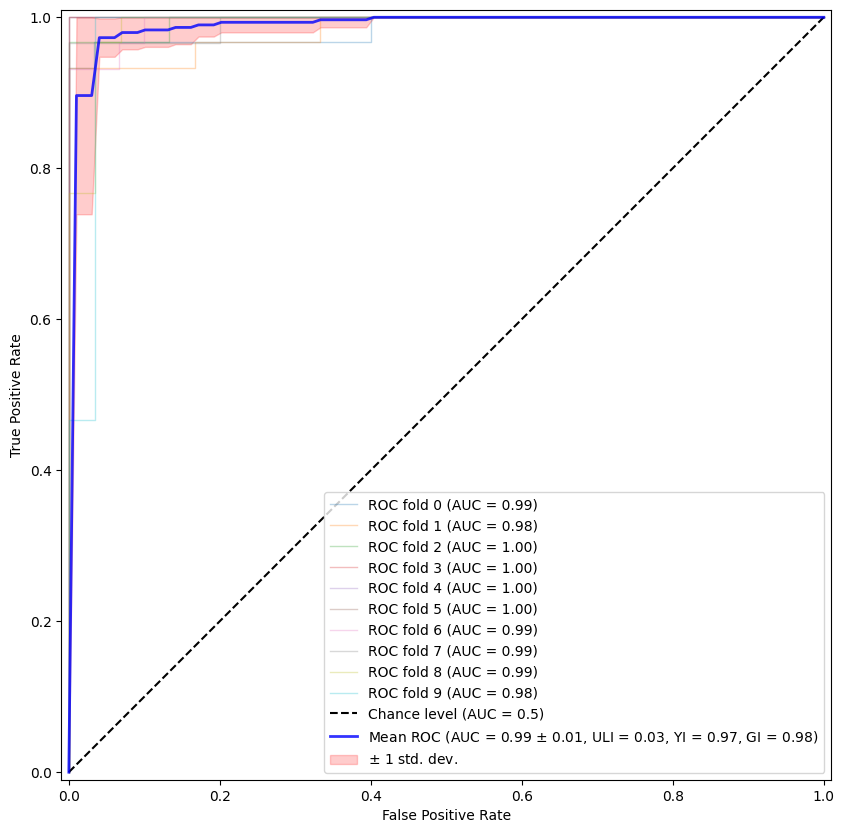

acc: 0.9815436241610739
spec: 0.9899328859060402
pc : 0.9897610921501706
f1 : 0.9813874788494078
sen: 0.9731543624161074


In [28]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_LR):
    """
    Calculates the Unit Less Index (ULI) for all thresholds.
    ULI measures the Euclidean distance from the point (0,1) on the ROC curve.
    Lower ULI indicates better performance (closer to perfect classification).
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_LR)
    for i in range(len(fpr)):
        # Calculate distance to the top-left corner (0, 1)
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the best (minimum) distance found

def ULI_threshold(Y_test, proba_LR):
    """
    Finds the optimal probability threshold that minimizes the ULI.
    Returns the specific FPR, TPR, and Threshold value corresponding to that point.
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible distance (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_LR)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    # Return the coordinates and threshold of the optimal point
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_LR):
    """
    Calculates the Youden's Index (YI).
    YI = Sensitivity + Specificity - 1 (or TPR - FPR).
    Maximize YI to find the optimal cut-off point.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_LR)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i]) # Equivalent to Sensitivity + Specificity - 1
        ulis.append(side)
    return round(max(ulis), 3)

# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all K-folds
cm_LR_TP = []
cm_LR_FP = []
cm_LR_TN = []
cm_LR_FN = []

# Lists to store ROC curve data for plotting the Mean ROC later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for averaging ROC curves

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# We iterate through each fold defined by the 'cv' splitter (StratifiedKFold)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    # X_train and Y_train here refer to the entire training set passed to CV
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Train Logistic Regression Model
    # Uses best hyperparameters found previously via GridSearchCV (gs_LR)
    model_LR = LogisticRegression(
        random_state=42, 
        C=gs_LR.best_params_['C'], 
        class_weight=gs_LR.best_params_['class_weight'], 
        fit_intercept=gs_LR.best_params_['fit_intercept'], 
        penalty=gs_LR.best_params_['penalty'], 
        solver=gs_LR.best_params_['solver'] 
    )
    model_LR.fit(x_train, y_train)

    # 3. Predict Probabilities
    # We need probabilities (not hard labels) to calculate ROC and find thresholds
    y_pred_LR = model_LR.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold & Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_LR)
    YI_1 = calc_YI(y_test, y_pred_LR)
    
    # Find the specific threshold that minimizes distance to perfect classification
    x_roc_1, y_roc_1, thresh_mainLR_b = ULI_threshold(y_test, y_pred_LR)

    # 5. Apply Optimal Threshold
    # Instead of default 0.5, we use the ULI-optimized threshold for hard classification
    custom_threshold = thresh_mainLR_b
    y_pred_hard = (y_pred_LR >= thresh_mainLR_b).astype(int) # Renamed to avoid confusion with probas

    # 6. Confusion Matrix & Accumulation
    # Compute CM for this specific fold
    cm_LR = confusion_matrix(y_test, y_pred_hard)

    # Extract and store components (TP, FP, TN, FN)
    TN = cm_LR[0,0]
    cm_LR_TN.append(TN)
    FP = cm_LR[0,1]
    cm_LR_FP.append(FP)
    TP = cm_LR[1,1]
    cm_LR_TP.append(TP)
    FN = cm_LR[1,0]
    cm_LR_FN.append(FN)

    # Calculate Cumulative Sums (Total counts across all folds processed so far)
    # NOTE: These variables update in every loop iteration
    TN_t = np.sum(cm_LR_TN)
    FP_t = np.sum(cm_LR_FP)
    TP_t = np.sum(cm_LR_TP)
    FN_t = np.sum(cm_LR_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These metrics represent the weighted average performance across folds up to this point
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_LR,
        x_test, # Note: .from_estimator() uses the model to predict internally
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Only plot chance line on last fold
    )

    # Interpolate TPR to allow averaging later
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Ensure curve ends at (1,1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: ULI_1 and YI_1 in the label will only show the value from the *last fold* loop
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Standard Deviation Shade (Confidence Interval)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# These print the cumulative metrics calculated after the FINAL fold
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [29]:
# Predicting the test set

# Probability prediction of LR
proba_LR = model_LR.predict_proba(X_test)[:, 1]

# Logical prediction of LR
prob_LR_SIMPLE = model_LR.predict(X_test)

print(model_LR.predict(X_test))
print(model_LR.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 1]
[0.88624938 0.87272083 0.99739473 0.04787818 0.99919819 0.11037181
 0.54116557 0.75750054 0.94290841 0.17787111 0.9948842  0.97614996
 0.0206646  0.19728118 0.81776176 0.12153353 0.13046641 0.03395624
 0.41150951 0.18373451 0.9995541  0.94418773 0.82732369 0.98374246
 0.20856225 0.15645275 0.00739716 0.32823929 0.02369351 0.0915589
 0.97247311 0.00729779 0.31457046 0.11933452 0.98601293 0.83656254
 0.10319577 0.00678549 0.98572202 0.25789436 0.03963787 0.42199094
 0.06065944 0.85072905 0.89366935 0.99730016 0.46283751 0.04317156
 0.99999995 0.11460052 0.05542111 0.81433352 0.9998877  0.15028455
 0.05253614 0.29526128 0.94336296 0.87917422 0.15046106 0.01957029
 0.29643582 0.01609647 0.0366452  0.89012137 0.55727038 0.08003552
 0.04743319 0.09648704 0.11130362 0.27259492 0.13146035 0.30234537
 0.10979418 0.9021094

In [30]:
# Predictions based on optimum threshold (Threshold optimized on the TRAINING set)
predictions_LR = (proba_LR >= thresh_mainLR_b).astype(int)
print(predictions_LR)

[0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 1]


spec: 0.96875
acc: 0.9534883720930233
pc : 0.9807692307692307
f1 : 0.9622641509433962
AUC: 0.9924768518518519
sen: 0.9444444444444444


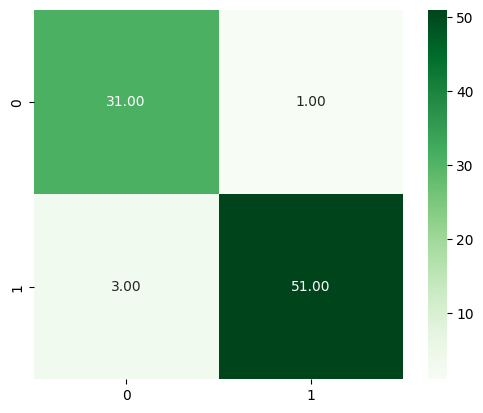

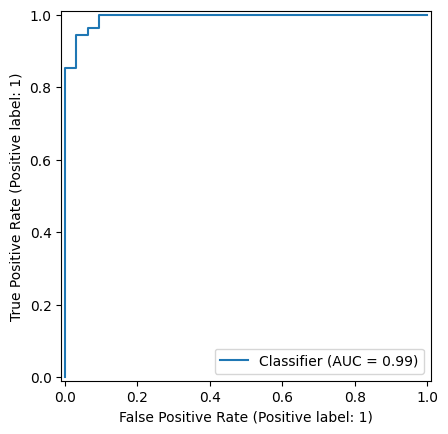

In [78]:
# Metrics for the test --> LR ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_LR)
acc = accuracy_score(Y_test, predictions_LR)
pc = precision_score(Y_test, predictions_LR)
f1 = f1_score(Y_test, predictions_LR)
AUC = roc_auc_score(Y_test, proba_LR)
sen = recall_score(Y_test, predictions_LR)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_LR)

# SVC model

In [32]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()

n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)



# List of parameters for SVC
parameters_SVC = ({'random_state':[42], 'C':[0.5, 2, 4, 10, 20], 'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 'gamma':['auto', 'scale']})


model_SVC = SVC()

In [33]:
gs_SVC = GridSearchCV(estimator=model_SVC, param_grid=parameters_SVC, cv=cv, scoring='accuracy')
gs_SVC.fit(X_train, Y_train)
print(gs_SVC.best_params_)

{'C': 2, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42}


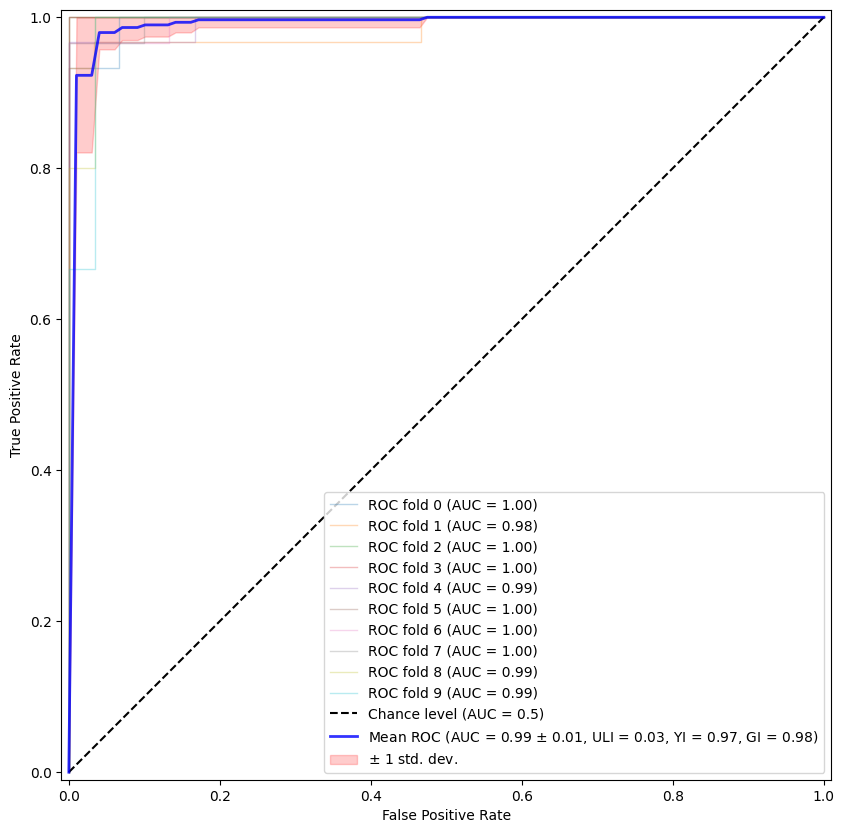

acc: 0.9848993288590604
spec: 0.9899328859060402
pc : 0.9898305084745763
f1 : 0.984822934232715
sen: 0.9798657718120806


In [34]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_SVC):
    """
    Calculates the Unit Less Index (ULI) for all possible thresholds.
    The ULI measures the Euclidean distance from a point on the ROC curve 
    to the ideal classification point (0, 1) [Top-Left corner].
    A lower ULI indicates a better balance between Sensitivity and Specificity.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_SVC)
    for i in range(len(fpr)):
        # Calculate Euclidean distance to (0, 1)
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the minimum distance found (Best theoretical performance)

def ULI_threshold(Y_test, proba_SVC):
    """
    Identifies the specific probability threshold that minimizes the ULI.
    Returns the False Positive Rate (FPR), True Positive Rate (TPR), and 
    the actual probability threshold value at that optimal point.
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible distance (sqrt(2) ≈ 1.414)
    fpr, tpr, threshold = roc_curve(Y_test, proba_SVC)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    # Return optimal coordinates and the threshold to use for classification
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_SVC):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1.
    This metric captures the maximum vertical distance between the ROC curve 
    and the diagonal chance line. Higher is better.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_SVC)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)

# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all K-folds
# These allow us to calculate "Macro" or "Pooled" performance metrics later
cm_SVC_TP = []
cm_SVC_FP = []
cm_SVC_TN = []
cm_SVC_FN = []

# Lists to store ROC curve data for plotting the Mean ROC later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis (FPR) for averaging ROC curves

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# We iterate through each fold defined by the 'cv' splitter (StratifiedKFold)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    # X_train and Y_train here refer to the global training set passed to CV
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train SVC Model
    # We initialize SVC with best hyperparameters found via GridSearchCV (gs_SVC).
    # 'probability=True' is CRITICAL here to enable .predict_proba() for ROC calculation.
    model_SVC = SVC(
        random_state=42, 
        C=gs_SVC.best_params_['C'], 
        kernel=gs_SVC.best_params_['kernel'], 
        gamma=gs_SVC.best_params_['gamma'], 
        probability=True
    )
    model_SVC.fit(x_train, y_train)

    # 3. Predict Probabilities
    # We extract probabilities for the positive class (index 1)
    y_pred_SVC = model_SVC.predict_proba(x_test)[:,1]

    # 4. Calculate Optimization Metrics (ULI, YI) for this fold
    # These metrics help assess how "confident" the model is in its best-case scenario
    ULI_1 = calc_ULI(y_test, y_pred_SVC)
    YI_1 = calc_YI(y_test, y_pred_SVC)
    
    # Find the specific threshold that optimizes performance (minimizes ULI)
    x_roc_1, y_roc_1, thresh_mainSVC_b = ULI_threshold(y_test, y_pred_SVC)

    # 5. Apply Optimal Threshold for Classification
    # Instead of the default 0.5 threshold, we classify based on the ULI-optimized threshold
    custom_threshold = thresh_mainSVC_b
    y_pred_hard = (y_pred_SVC >= thresh_mainSVC_b).astype(int) # Renamed variable for clarity

    # 6. Confusion Matrix & Accumulation
    # Compute CM for this specific fold using the optimized predictions
    cm_SVC = confusion_matrix(y_test, y_pred_hard)

    # Extract components (TP, FP, TN, FN)
    TN = cm_SVC[0,0]
    cm_SVC_TN.append(TN)
    FP = cm_SVC[0,1]
    cm_SVC_FP.append(FP)
    TP = cm_SVC[1,1]
    cm_SVC_TP.append(TP)
    FN = cm_SVC[1,0]
    cm_SVC_FN.append(FN)

    # Calculate Cumulative Sums (Total counts across all folds processed so far)
    # These variables update in every loop iteration to track total performance
    TN_t = np.sum(cm_SVC_TN)
    FP_t = np.sum(cm_SVC_FP)
    TP_t = np.sum(cm_SVC_TP)
    FN_t = np.sum(cm_SVC_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These represent the weighted average performance across folds up to this point
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_SVC,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Only plot the dashed chance line on the last fold
    )

    # Interpolate TPR to allow averaging later
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Ensure curve ends at (1, 1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: The label includes ULI and YI from the *last fold* iteration (ULI_1, YI_1). 
# ideally, these should be averaged too, but currently, it shows the last fold's values.
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Standard Deviation Shade (Confidence Interval)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print the final cumulative metrics calculated after the last fold
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [35]:
# Predicting the test set

# Probability prediction of SVC
proba_SVC = model_SVC.predict_proba(X_test)[:, 1]

# Logical prediction of SVC
prob_SVC_SIMPLE = model_SVC.predict(X_test)

print(model_SVC.predict(X_test))
print(model_SVC.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 1]
[9.98051092e-01 9.99413727e-01 9.93352688e-01 6.91721398e-09
 9.91539929e-01 4.03332747e-03 6.41374623e-01 9.76331285e-01
 9.97024762e-01 3.76778449e-03 9.99780267e-01 9.88600477e-01
 1.41734873e-07 3.17078304e-02 9.38835777e-01 9.45792834e-06
 2.95506484e-03 1.21705386e-07 4.37788546e-01 8.89456399e-03
 9.80989144e-01 9.98722131e-01 9.97602098e-01 9.99970224e-01
 4.75855046e-02 4.53209379e-06 1.43535514e-09 1.50451876e-01
 1.21656297e-07 5.04701224e-03 9.99466986e-01 5.99108931e-08
 1.74983352e-01 2.48758060e-06 9.90629321e-01 9.99267119e-01
 9.44831133e-06 4.55947958e-10 9.96555897e-01 6.72403491e-02
 4.05763426e-02 4.77621173e-01 1.43530865e-07 9.98041770e-01
 9.99643676e-01 9.99599004e-01 5.85184348e-01 1.52536083e-08
 2.42803431e-01 3.02049341e-03 2.85550160e-06 9.97609987e-01
 8.85412015e-01 1.22521037e-05 

In [36]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainSVC_b is being used which is the threshold for train dataset
predictions_SVC = (proba_SVC >= thresh_mainSVC_b).astype(int)
print(predictions_SVC)

[0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 1 1]


spec: 0.90625
acc: 0.9534883720930233
pc : 0.9464285714285714
f1 : 0.9636363636363636
AUC: 0.9803240740740741
sen: 0.9814814814814815


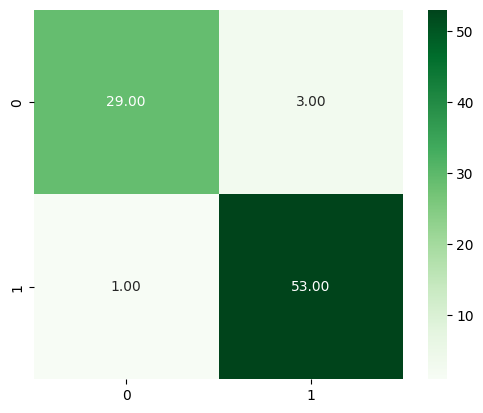

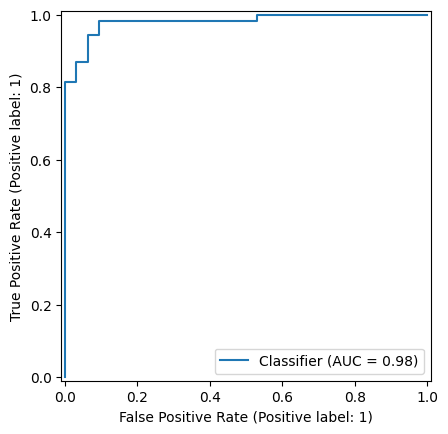

In [79]:
# Metrics for the test --> SVC ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_SVC)
acc = accuracy_score(Y_test, predictions_SVC)
pc = precision_score(Y_test, predictions_SVC)
f1 = f1_score(Y_test, predictions_SVC)
AUC = roc_auc_score(Y_test, proba_SVC)
sen = recall_score(Y_test, predictions_SVC)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_SVC)

# DT model

In [38]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)




# List of parameters for Decision Tree
parameters_DT = ({'random_state':[42], 'criterion':['gini', 'entropy', 'log_loss'], 'splitter':['best', 'random'], 'max_depth':[10, 20, 30, 40], 'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4]})


model_DT = DecisionTreeClassifier()

In [39]:
gs_DT = GridSearchCV(estimator=model_DT, param_grid=parameters_DT, cv=cv, scoring='accuracy')
gs_DT.fit(X_train, Y_train)
print(gs_DT.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'random'}


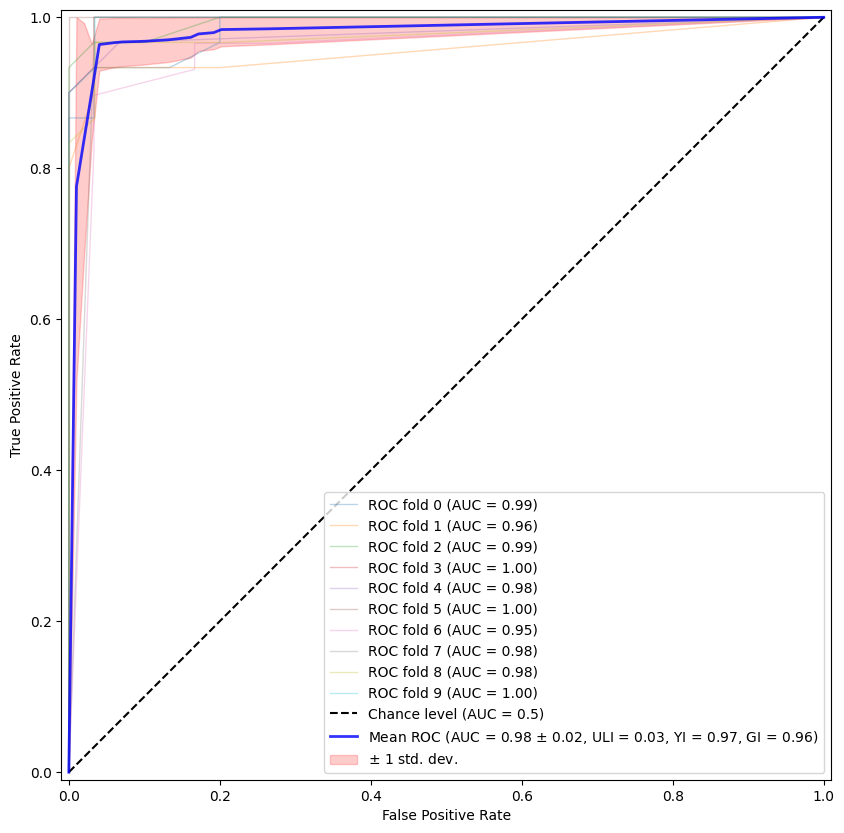

acc: 0.9664429530201343
spec: 0.9664429530201343
pc : 0.9664429530201343
f1 : 0.9664429530201343
sen: 0.9664429530201343


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, auc
from sklearn import metrics

# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_DT):
    """
    Calculates the Unit Less Index (ULI) for all thresholds.
    ULI measures the distance from the perfect classification point (0, 1) on the ROC curve.
    Formula: sqrt((TPR - 1)^2 + FPR^2)
    A value closer to 0 indicates better performance.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_DT)
    for i in range(len(fpr)):
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the best (minimum) distance found

def ULI_threshold(Y_test, proba_DT):
    """
    Finds the exact probability threshold that minimizes the ULI.
    This threshold balances Sensitivity and Specificity based on the ULI criterion.
    Returns: (FPR, TPR, Optimal Threshold)
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_DT)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_DT):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1 (or TPR - FPR).
    It identifies the threshold that maximizes the vertical distance from the chance line.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_DT)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)


# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all folds.
# We will sum these up to calculate "Pooled" performance metrics.
cm_DT_TP = []
cm_DT_FP = []
cm_DT_TN = []
cm_DT_FN = []

# Lists to store ROC curve data for averaging later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for the mean ROC plot

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# Iterate over each split defined by the Cross-Validator (cv)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train Decision Tree
    # We use hyperparameters from a previous GridSearchCV (gs_DT).
    # Note: 'class_weight="balanced"' is used to handle potential class imbalance automatically.
    model_DT = DecisionTreeClassifier(
        random_state=42, 
        class_weight='balanced', 
        criterion=gs_DT.best_params_['criterion'], 
        max_depth=gs_DT.best_params_['max_depth'], 
        min_samples_leaf=gs_DT.best_params_['min_samples_leaf'], 
        min_samples_split=gs_DT.best_params_['min_samples_split'], 
        splitter=gs_DT.best_params_['splitter']
    )
    model_DT.fit(x_train, y_train)

    # 3. Predict Probabilities
    # Probabilities are needed for ROC calculation and threshold tuning.
    y_pred_DT = model_DT.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_DT)
    YI_1 = calc_YI(y_test, y_pred_DT)
    
    # Identify the optimal threshold for THIS specific fold
    x_roc_1, y_roc_1, thresh_mainDT_b = ULI_threshold(y_test, y_pred_DT)

    # 5. Apply Optimal Threshold
    # Convert probabilities to binary predictions (0 or 1) using the calculated threshold.
    custom_threshold = thresh_mainDT_b
    y_pred_hard = (y_pred_DT >= thresh_mainDT_b).astype(int) # Renamed for clarity

    # 6. Confusion Matrix & Accumulation
    # Calculate CM for the current fold
    cm_DT = confusion_matrix(y_test, y_pred_hard)

    # Store the components (TN, FP, TP, FN)
    TN = cm_DT[0,0]
    cm_DT_TN.append(TN)
    FP = cm_DT[0,1]
    cm_DT_FP.append(FP)
    TP = cm_DT[1,1]
    cm_DT_TP.append(TP)
    FN = cm_DT[1,0]
    cm_DT_FN.append(FN)

    # Update Cumulative Sums (Total counts across all processed folds)
    TN_t = np.sum(cm_DT_TN)
    FP_t = np.sum(cm_DT_FP)
    TP_t = np.sum(cm_DT_TP)
    FN_t = np.sum(cm_DT_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These metrics reflect the "Pooled" performance up to the current fold.
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_DT,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Plot chance line only on the last fold
    )

    # Interpolate TPR for Mean ROC calculation
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Anchor the end of the curve at (1, 1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: The label includes ULI/YI from the LAST fold (ULI_1, YI_1).
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Confidence Interval (Standard Deviation)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print the final pooled metrics calculated after all folds
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [41]:
# Predicting the test set

# Probability prediction of DT
proba_DT = model_DT.predict_proba(X_test)[:, 1]

# Logical prediction of DT
prob_DT_SIMPLE = model_DT.predict(X_test)

print(model_DT.predict(X_test))
print(model_DT.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1
 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 0 1]
[0.74930103 1.         1.         0.         1.         0.4990689
 0.66583851 1.         1.         0.         1.         1.
 0.         0.59910581 0.83281541 0.         0.         0.
 0.16615003 0.         1.         1.         1.         1.
 0.16615003 0.         0.         0.59910581 0.         0.
 1.         0.         0.         0.         1.         1.
 0.         0.         1.         0.74930103 0.1812648  0.
 0.         0.66583851 1.         1.         0.         0.
 1.         0.         0.         1.         1.         0.
 0.         0.         1.         1.         0.         0.
 0.74930103 0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.19940476 0.77713339 1.         0.16615003
 0.         0.         0.         1.      

In [42]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainDT_b is being used which is the threshold for train dataset
predictions_DT = (proba_DT >= thresh_mainDT_b).astype(int)
print(predictions_DT)

[0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 0 1]


spec: 0.90625
acc: 0.9186046511627907
pc : 0.9433962264150944
f1 : 0.9345794392523364
AUC: 0.916087962962963
sen: 0.9259259259259259


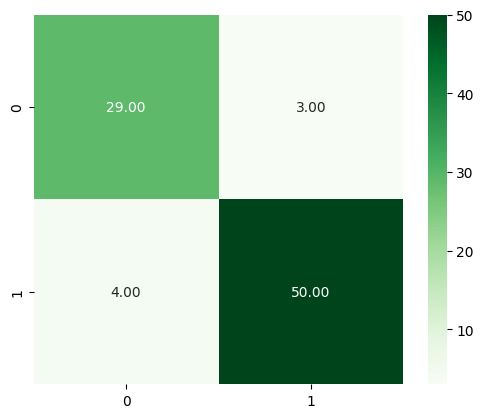

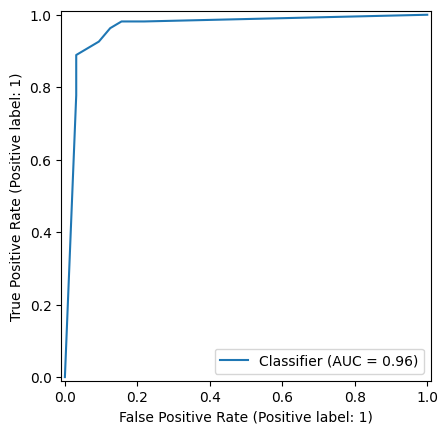

In [ ]:
# Metrics for the test --> DT ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_DT)
acc = accuracy_score(Y_test, predictions_DT)
pc = precision_score(Y_test, predictions_DT)
f1 = f1_score(Y_test, predictions_DT)
AUC = roc_auc_score(Y_test, proba_DT)
sen = recall_score(Y_test, predictions_DT)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_DT)

# KNN model

In [44]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)



# List of parameters for Decision Tree
parameters_KNN = ({'n_neighbors':list(range(1,10)), 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1,2], 'metric':['minkowski', 'euclidean', 'manhattan'], 'leaf_size':[10,20,30,40]})


model_KNN = KNeighborsClassifier()

In [45]:
gs_KNN = GridSearchCV(estimator=model_KNN, param_grid=parameters_KNN, cv=cv, scoring='accuracy')
gs_KNN.fit(X_train, Y_train)
print(gs_KNN.best_params_)

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


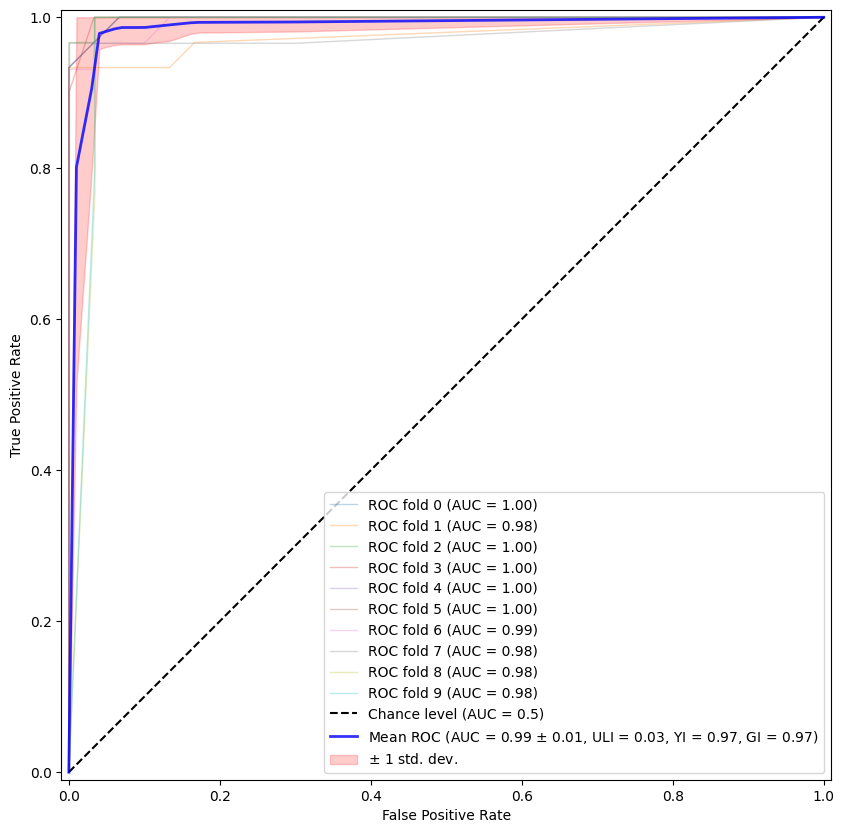

acc: 0.9748322147651006
spec: 0.9865771812080537
pc : 0.9862542955326461
f1 : 0.9745331069609509
sen: 0.9630872483221476


In [46]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_KNN):
    """
    Calculates the Unit Less Index (ULI) for all possible probability thresholds.
    The ULI measures the Euclidean distance from a specific point on the ROC curve 
    to the 'perfect classification' point (Top-Left corner: FPR=0, TPR=1).
    Lower ULI values indicate better performance.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_KNN)
    for i in range(len(fpr)):
        # Calculate distance to (0, 1)
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the minimum distance (best score) found

def ULI_threshold(Y_test, proba_KNN):
    """
    Identifies the specific probability threshold that minimizes the ULI.
    This function finds the optimal operating point on the ROC curve.
    Returns: The specific FPR, TPR, and the probability Threshold value at that point.
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible distance (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_KNN)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_KNN):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1 (or TPR - FPR).
    This metric measures the maximum vertical distance between the ROC curve 
    and the diagonal chance line.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_KNN)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)


# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all K-folds
# We sum these up to calculate "Pooled" metrics (Macro-average performance)
cm_KNN_TP = []
cm_KNN_FP = []
cm_KNN_TN = []
cm_KNN_FN = []

# Lists to store ROC curve data for plotting the Mean ROC later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for averaging ROC curves

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# We iterate through each split defined by the 'cv' object (StratifiedKFold)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train KNN Model
    # We initialize KNN using the best hyperparameters found previously via GridSearchCV (gs_KNN).
    # All parameters (n_neighbors, weights, algorithm, p, metric, leaf_size) are explicitly passed.
    model_KNN = KNeighborsClassifier(
        n_neighbors=gs_KNN.best_params_['n_neighbors'],
        weights=gs_KNN.best_params_['weights'],
        algorithm=gs_KNN.best_params_['algorithm'],
        p=gs_KNN.best_params_['p'],
        metric=gs_KNN.best_params_['metric'],
        leaf_size=gs_KNN.best_params_['leaf_size']
    )
    model_KNN.fit(x_train, y_train)

    # 3. Predict Probabilities
    # We extract the probability of the positive class (index 1) for ROC analysis.
    y_pred_KNN = model_KNN.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_KNN)
    YI_1 = calc_YI(y_test, y_pred_KNN)
    
    # Identify the specific threshold that optimizes performance (minimizes ULI) for THIS fold
    x_roc_1, y_roc_1, thresh_mainKNN_b = ULI_threshold(y_test, y_pred_KNN)

    # 5. Apply Optimal Threshold
    # Instead of the default 0.5, we use the optimized threshold to convert probabilities to classes.
    custom_threshold = thresh_mainKNN_b
    y_pred_hard = (y_pred_KNN >= thresh_mainKNN_b).astype(int) # Renamed for clarity

    # 6. Confusion Matrix & Accumulation
    # Compute CM for the current fold
    cm_KNN = confusion_matrix(y_test, y_pred_hard)

    # Store components (TN, FP, TP, FN)
    TN = cm_KNN[0,0]
    cm_KNN_TN.append(TN)
    FP = cm_KNN[0,1]
    cm_KNN_FP.append(FP)
    TP = cm_KNN[1,1]
    cm_KNN_TP.append(TP)
    FN = cm_KNN[1,0]
    cm_KNN_FN.append(FN)

    # Calculate Cumulative Sums (Total counts across all folds processed so far)
    TN_t = np.sum(cm_KNN_TN)
    FP_t = np.sum(cm_KNN_FP)
    TP_t = np.sum(cm_KNN_TP)
    FN_t = np.sum(cm_KNN_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These metrics represent the weighted average performance across all folds up to this point.
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_KNN,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Only plot the chance line on the last fold
    )

    # Interpolate TPR to allow averaging later
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Ensure curve ends at (1, 1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: The label includes ULI/YI from the *last fold* iteration (ULI_1, YI_1).
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Standard Deviation Shade (Confidence Interval)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print the final pooled metrics calculated after the last fold
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [47]:
# Predicting the test set

# Probability prediction of KNN
proba_KNN = model_KNN.predict_proba(X_test)[:, 1]

# Logical prediction of KNN
prob_KNN_SIMPLE = model_KNN.predict(X_test)

print(model_KNN.predict(X_test))
print(model_KNN.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 0 1]
[1.         1.         1.         0.         1.         0.11111111
 0.66666667 1.         1.         0.         1.         1.
 0.         0.         1.         0.         0.         0.
 0.44444444 0.         1.         1.         1.         1.
 0.22222222 0.         0.         0.11111111 0.         0.
 1.         0.         0.44444444 0.         1.         1.
 0.         0.         1.         0.         0.         0.55555556
 0.         1.         1.         1.         0.55555556 0.
 1.         0.         0.         1.         1.         0.11111111
 0.         0.         1.         1.         0.         0.
 0.33333333 0.         0.         0.88888889 0.55555556 0.
 0.         0.         0.         0.11111111 0.         0.
 0.         1.         0.33333333 1.         1.         0.22222222
 0.         0.         0.

In [48]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainKNN_b is being used which is the threshold for train dataset
predictions_KNN = (proba_KNN >= thresh_mainKNN_b).astype(int)
print(predictions_KNN)

[0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 0 1]


spec: 0.9375
acc: 0.9534883720930233
pc : 0.9629629629629629
f1 : 0.9629629629629629
AUC: 0.9502314814814814
sen: 0.9629629629629629


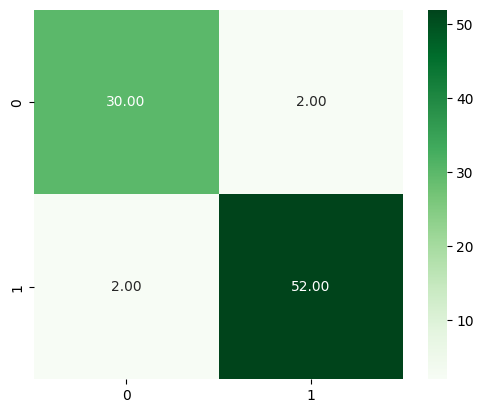

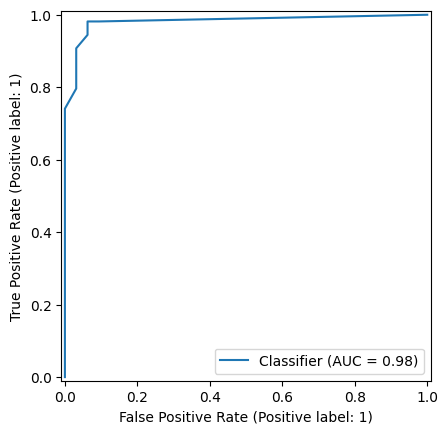

In [ ]:
# Metrics for the test --> KNN ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_KNN)
acc = accuracy_score(Y_test, predictions_KNN)
pc = precision_score(Y_test, predictions_KNN)
f1 = f1_score(Y_test, predictions_KNN)
AUC = roc_auc_score(Y_test, proba_KNN)
sen = recall_score(Y_test, predictions_KNN)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_KNN)

# XGB model

In [50]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)




# List of parameters for XGBoost
parameters_XGB = ({'n_estimators':[50, 100, 200, 300], 'max_depth':[3, 5, 7, 9], 'learning_rate':[0.01, 0.1], 'subsample':[0.6, 0.8, 1.0], 'colsample_bytree':[0.6, 0.8, 1.0], 'gamma':[0, 0.1, 0.2, 0.3]})


model_XGB = XGBClassifier()

In [51]:
gs_XGB = GridSearchCV(estimator=model_XGB, param_grid=parameters_XGB, cv=cv, scoring='accuracy')
gs_XGB.fit(X_train, Y_train)
print(gs_XGB.best_params_)

{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


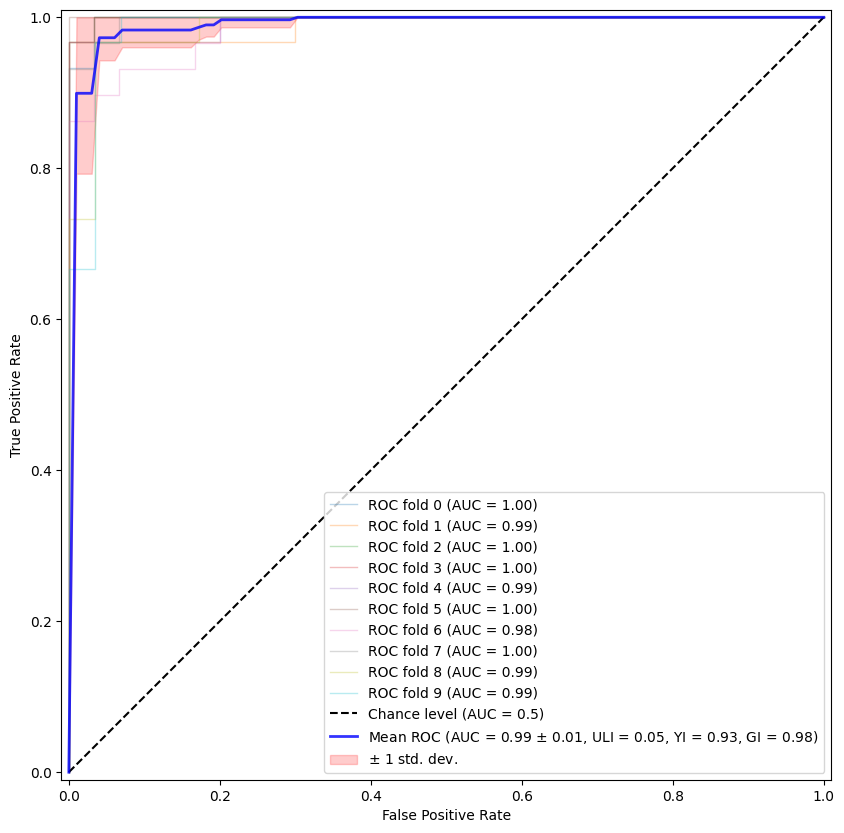

acc: 0.9748322147651006
spec: 0.9798657718120806
pc : 0.9796610169491525
f1 : 0.9747048903878585
sen: 0.9697986577181208


In [71]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_XGB):
    """
    Calculates the Unit Less Index (ULI) for all thresholds.
    ULI measures the Euclidean distance from the perfect classification point (0,1).
    Lower is better.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_XGB)
    for i in range(len(fpr)):
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return minimum distance found

def ULI_threshold(Y_test, proba_XGB):
    """
    Finds the specific threshold that minimizes ULI.
    This helps find the optimal balance point between Sensitivity and Specificity.
    Returns: (FPR, TPR, Optimal Threshold)
    """
    uli_list = []
    uli = 2 # Initialize with max possible distance (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_XGB)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_XGB):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1.
    Measures the maximum vertical distance from the ROC curve to the diagonal chance line.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_XGB)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)


# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix stats across all K-folds
# Used to calculate "Pooled" performance metrics later
cm_XGB_TP = []
cm_XGB_FP = []
cm_XGB_TN = []
cm_XGB_FN = []

# Lists to store ROC data for averaging
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for Mean ROC

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train XGBoost
    # Note: We use a fixed configuration here rather than a GridSearchCV object
    model_XGB = XGBClassifier(
        objective="binary:logistic",
        eval_metric='logloss',
        tree_method="exact", # 'hist' is faster for large data, 'exact' for small
        random_state=42,
        n_estimators=100,      # High number allowed because we use early stopping
        learning_rate=0.1,     # Low learning rate for robust generalization
        max_depth=7,           # Deep trees (beware of overfitting on small data)
        gamma=0.2,               # Minimum loss reduction to make a split (prevents overfitting)
        subsample=0.8,          # Train on 80% of data per tree (prevents overfitting)
        colsample_bytree=1,   # Use 80% of features per tree
        reg_lambda=1,           # L2 Regularization
        scale_pos_weight=2,     # Handles class imbalance (weight for positive class)
        n_jobs=-1,
    )
    
    # Fit with Early Stopping
    # Monitoring 'x_test' allows the model to stop training if validation error stops improving
    # This prevents the 'n_estimators=5000' from overfitting.
    model_XGB.fit(
        x_train, y_train,
        eval_set=[(x_test, y_test)],
        verbose=False # Set to True to see training logs per epoch
    )

    # 3. Predict Probabilities
    # Get probabilities for the positive class (1)
    y_pred_XGB = model_XGB.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_XGB)
    YI_1 = calc_YI(y_test, y_pred_XGB)
    
    # Find optimal threshold for this specific fold
    x_roc_1, y_roc_1, thresh_mainXGB_b = ULI_threshold(y_test, y_pred_XGB)

    # 5. Apply Optimal Threshold
    # Convert probability to class label using the custom threshold
    custom_threshold = thresh_mainXGB_b
    y_pred_hard = (y_pred_XGB >= thresh_mainXGB_b).astype(int) # Renamed for clarity

    # 6. Confusion Matrix & Accumulation
    # Compute CM for current fold
    cm_XGB = confusion_matrix(y_test, y_pred_hard)

    # Store components
    TN = cm_XGB[0,0]
    cm_XGB_TN.append(TN)
    FP = cm_XGB[0,1]
    cm_XGB_FP.append(FP)
    TP = cm_XGB[1,1]
    cm_XGB_TP.append(TP)
    FN = cm_XGB[1,0]
    cm_XGB_FN.append(FN)

    # Update Cumulative Sums
    TN_t = np.sum(cm_XGB_TN)
    FP_t = np.sum(cm_XGB_FP)
    TP_t = np.sum(cm_XGB_TP)
    FN_t = np.sum(cm_XGB_FN)

    # 7. Calculate Cumulative Performance Metrics
    # Weighted average performance across all folds processed so far
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    # Note: .from_estimator will use the model's default predict_proba (0.5 threshold logic for plots)
    # The AUC calculation is threshold-independent.
    viz = RocCurveDisplay.from_estimator(
        model_XGB,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )

    # Interpolate TPR for Mean ROC calculation
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Shows the average performance across all folds
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Confidence Interval (Standard Deviation)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print final pooled metrics
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [72]:
# Predicting the test set

# Probability prediction of XGB
proba_XGB = model_XGB.predict_proba(X_test)[:, 1]

# Logical prediction of XGB
prob_XGB_SIMPLE = model_XGB.predict(X_test)

print(model_XGB.predict(X_test))
print(model_XGB.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 1 1]
[9.9573749e-01 9.9768829e-01 9.9902725e-01 8.5580349e-04 9.9908954e-01
 6.0877800e-03 6.7643976e-01 9.9759966e-01 9.9807787e-01 7.3302984e-03
 9.9848050e-01 9.9753672e-01 1.0121465e-03 1.8740594e-02 9.7217137e-01
 9.0897083e-04 3.5898089e-03 2.5939345e-03 1.4636958e-01 2.4693608e-03
 9.9887437e-01 9.9749339e-01 9.9702734e-01 9.9908894e-01 2.7329266e-02
 7.6544285e-04 4.8744678e-04 7.0765078e-02 5.4651499e-04 4.6890378e-03
 9.9827558e-01 5.8376789e-04 8.6998641e-02 1.1032820e-03 9.9673128e-01
 9.9787283e-01 1.8230677e-03 4.8744678e-04 9.9872768e-01 3.9962268e-01
 2.7109504e-02 1.5058458e-02 5.2648783e-04 9.9796855e-01 9.9727535e-01
 9.9918222e-01 1.5481770e-02 6.5678358e-04 9.9854273e-01 3.5161972e-03
 5.5795908e-04 9.9831718e-01 9.9820054e-01 1.0487139e-02 7.6436996e-04
 1.2473047e-02 9.9803334e-01 9.8479551e-01 

In [73]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainXGB_b is being used which is the threshold for train dataset
predictions_XGB = (proba_XGB >= thresh_mainXGB_b).astype(int)
print(predictions_XGB)

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 1 0 1 0 0 1]


spec: 0.9375
acc: 0.8837209302325582
pc : 0.9583333333333334
f1 : 0.9019607843137255
AUC: 0.8946759259259259
sen: 0.8518518518518519


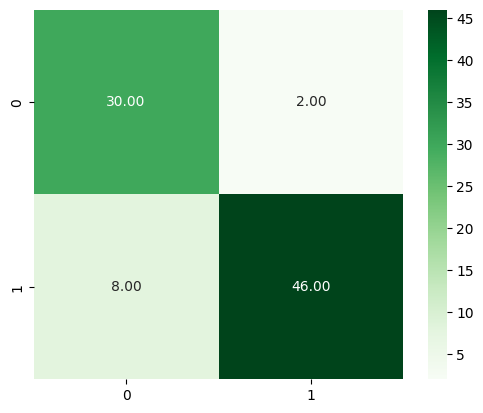

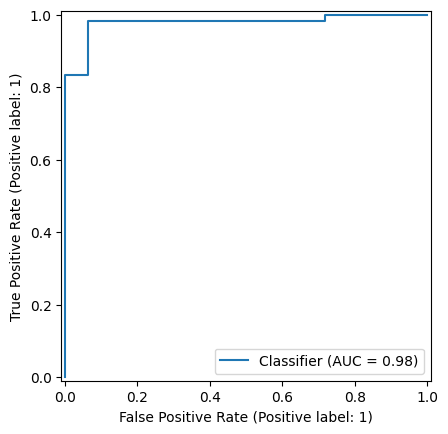

In [ ]:
# Metrics for the test --> XGB ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_XGB)
acc = accuracy_score(Y_test, predictions_XGB)
pc = precision_score(Y_test, predictions_XGB)
f1 = f1_score(Y_test, predictions_XGB)
AUC = roc_auc_score(Y_test, proba_XGB)
sen = recall_score(Y_test, predictions_XGB)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_XGB)

# NB model

In [56]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)



# List of parameters for Decision Tree
parameters_NB = ({'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],})


model_NB = GaussianNB()

In [57]:
gs_NB = GridSearchCV(estimator=model_NB, param_grid=parameters_NB, cv=cv, scoring='accuracy')
gs_NB.fit(X_train, Y_train)
print(gs_NB.best_params_)

{'var_smoothing': 1e-09}


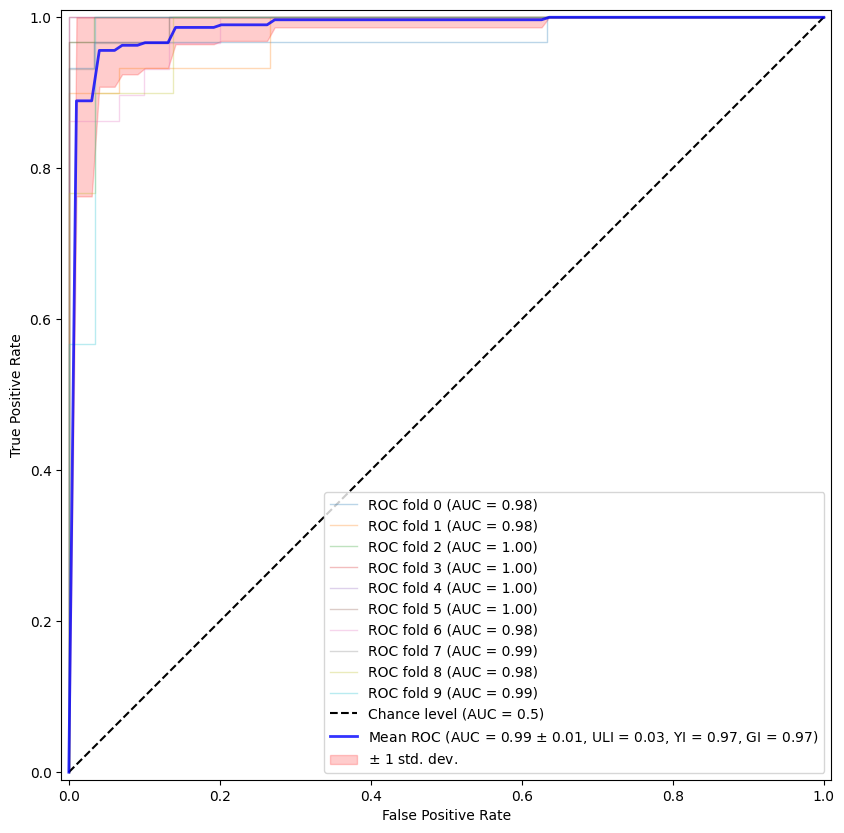

acc: 0.9664429530201343
spec: 0.9697986577181208
pc : 0.9695945945945946
f1 : 0.9663299663299664
sen: 0.9630872483221476


In [58]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_NB):
    """
    Calculates the Unit Less Index (ULI) across all thresholds.
    The ULI represents the Euclidean distance from a specific point on the ROC curve 
    to the ideal classification point (Top-Left corner: FPR=0, TPR=1).
    Lower ULI values correspond to better model performance.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_NB)
    for i in range(len(fpr)):
        # Calculate distance to (0, 1)
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the best (minimum) distance found

def ULI_threshold(Y_test, proba_NB):
    """
    Identifies the probability threshold that minimizes the ULI.
    This function finds the optimal operating point on the ROC curve where
    Sensitivity and Specificity are balanced according to the ULI criterion.
    Returns: (FPR, TPR, Optimal Threshold)
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible distance (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_NB)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_NB):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1 (or TPR - FPR).
    It measures the maximum vertical distance between the ROC curve 
    and the diagonal chance line (random guessing).
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_NB)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)


# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all folds.
# Summing these allows us to calculate "Pooled" performance metrics later.
cm_NB_TP = []
cm_NB_FP = []
cm_NB_TN = []
cm_NB_FN = []

# Lists to store ROC curve data for plotting the Mean ROC later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for averaging ROC curves

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# Iterate through each split defined by the 'cv' object (StratifiedKFold)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train Gaussian Naive Bayes Model
    # We initialize GaussianNB with the best 'var_smoothing' parameter found via GridSearchCV (gs_NB).
    # 'var_smoothing' adds a portion of the largest variance to all features to stabilize calculation.
    model_NB = GaussianNB(var_smoothing=gs_NB.best_params_['var_smoothing'])
    model_NB.fit(x_train, y_train)

    # 3. Predict Probabilities
    # Extract probabilities for the positive class (index 1) for ROC analysis.
    y_pred_NB = model_NB.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_NB)
    YI_1 = calc_YI(y_test, y_pred_NB)
    
    # Identify the specific threshold that optimizes performance (minimizes ULI) for THIS fold
    x_roc_1, y_roc_1, thresh_mainNB_b = ULI_threshold(y_test, y_pred_NB)

    # 5. Apply Optimal Threshold
    # Use the optimized threshold to convert probabilities to hard class labels (0 or 1).
    custom_threshold = thresh_mainNB_b
    y_pred_hard = (y_pred_NB >= thresh_mainNB_b).astype(int) # Renamed for clarity

    # 6. Confusion Matrix & Accumulation
    # Compute CM for the current fold
    cm_NB = confusion_matrix(y_test, y_pred_hard)

    # Store components (TN, FP, TP, FN)
    TN = cm_NB[0,0]
    cm_NB_TN.append(TN)
    FP = cm_NB[0,1]
    cm_NB_FP.append(FP)
    TP = cm_NB[1,1]
    cm_NB_TP.append(TP)
    FN = cm_NB[1,0]
    cm_NB_FN.append(FN)

    # Calculate Cumulative Sums (Total counts across all folds processed so far)
    TN_t = np.sum(cm_NB_TN)
    FP_t = np.sum(cm_NB_FP)
    TP_t = np.sum(cm_NB_TP)
    FN_t = np.sum(cm_NB_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These represent the weighted average performance across all folds up to this point.
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_NB,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Only plot chance line on the last fold
    )

    # Interpolate TPR to allow averaging later
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Ensure curve ends at (1, 1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: The label includes ULI/YI from the *last fold* iteration (ULI_1, YI_1).
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Standard Deviation Shade (Confidence Interval)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print the final pooled metrics calculated after the last fold
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [59]:
# Predicting the test set

# Probability prediction of NB
proba_NB = model_NB.predict_proba(X_test)[:, 1]

# Logical prediction of NB
prob_NB_SIMPLE = model_NB.predict(X_test)

print(model_NB.predict(X_test))
print(model_NB.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 1]
[9.99283087e-01 9.99531013e-01 1.00000000e+00 1.12513372e-03
 1.00000000e+00 3.34629634e-03 6.53496219e-01 9.99388305e-01
 9.99999992e-01 2.68424493e-02 1.00000000e+00 9.99985544e-01
 1.45090785e-04 2.40766065e-02 9.99478059e-01 6.05922314e-03
 5.39333991e-03 1.53643095e-04 1.36553971e-01 6.30767602e-03
 1.00000000e+00 9.99999987e-01 9.93842868e-01 1.00000000e+00
 8.82362636e-03 1.50480734e-02 2.36475368e-05 8.22980460e-02
 1.93926372e-04 9.07856123e-03 1.00000000e+00 7.05301977e-06
 3.95787423e-02 5.54444362e-03 1.00000000e+00 9.96477302e-01
 2.75461341e-03 7.95749056e-05 1.00000000e+00 8.27955030e-02
 2.20003878e-04 2.59008433e-01 2.85186126e-04 9.84667471e-01
 9.99976799e-01 1.00000000e+00 3.06761840e-01 4.75793201e-04
 1.00000000e+00 2.58117327e-03 6.00076455e-04 9.76926176e-01
 1.00000000e+00 2.04826639e-02 

In [60]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainNB_b is being used which is the threshold for train dataset
predictions_NB = (proba_NB >= thresh_mainNB_b).astype(int)
print(predictions_NB)

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 0 1 0 0 1]


spec: 0.9375
acc: 0.9302325581395349
pc : 0.9615384615384616
f1 : 0.9433962264150944
AUC: 0.931712962962963
sen: 0.9259259259259259


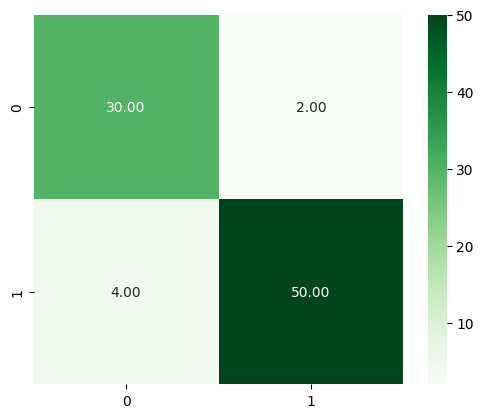

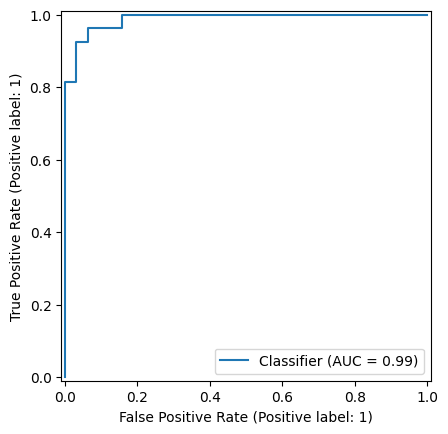

In [ ]:
# Metrics for the test --> NB ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_NB)
acc = accuracy_score(Y_test, predictions_NB)
pc = precision_score(Y_test, predictions_NB)
f1 = f1_score(Y_test, predictions_NB)
AUC = roc_auc_score(Y_test, proba_NB)
sen = recall_score(Y_test, predictions_NB)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_NB)

# RF model

In [62]:
### GRID SEARCH ###


# setting the cross validation
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()


n_splits = 10
cv = StratifiedKFold(n_splits= n_splits, random_state= 42, shuffle=True)



# List of parameters for Random Forest
parameters_RF = ({'random_state':[42], 'n_estimators':[100, 200, 300, 400], 'max_depth':[10, 20, 30, 40], 'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4], 'bootstrap':[True]})


model_RF = RandomForestClassifier()

In [63]:
gs_RF = GridSearchCV(estimator=model_RF, param_grid=parameters_RF, cv=cv, scoring='accuracy')
gs_RF.fit(X_train, Y_train)
print(gs_RF.best_params_)

{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}


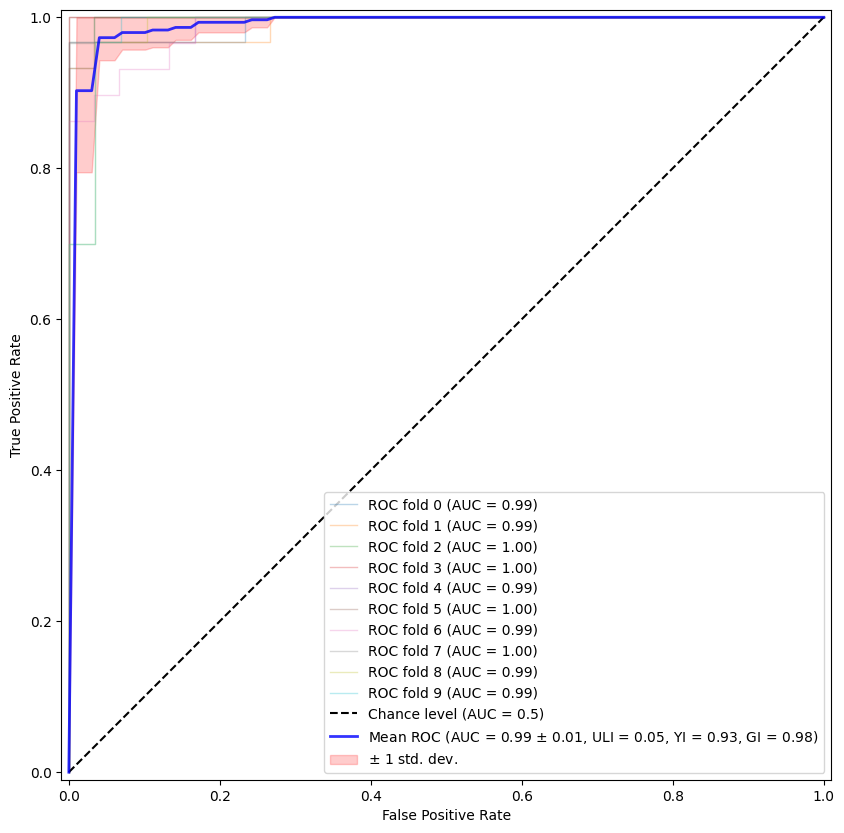

acc: 0.9748322147651006
spec: 0.9765100671140939
pc : 0.9764309764309764
f1 : 0.9747899159663865
sen: 0.9731543624161074


In [64]:
# ==========================================
# Helper Functions: Threshold Optimization
# ==========================================

def calc_ULI(Y_test, proba_RF):
    """
    Calculates the Unit Less Index (ULI) across all possible thresholds.
    The ULI measures the Euclidean distance from a specific point on the ROC curve 
    to the 'perfect classification' point (Top-Left corner: FPR=0, TPR=1).
    Lower ULI values indicate better performance (closer to perfect).
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_RF)
    for i in range(len(fpr)):
        # Calculate Euclidean distance to (0, 1)
        side = ((tpr[i]-1)**2 + (fpr[i]**2))**(1/2)
        ulis.append(side)
    return min(ulis) # Return the minimum distance found

def ULI_threshold(Y_test, proba_RF):
    """
    Identifies the probability threshold that minimizes the ULI.
    This function finds the optimal operating point on the ROC curve, balancing
    Sensitivity and Specificity according to the ULI criterion.
    Returns: (FPR, TPR, Optimal Threshold)
    """
    uli_list = []
    uli = 2 # Initialize with a value larger than max possible distance (sqrt(2))
    fpr, tpr, threshold = roc_curve(Y_test, proba_RF)
    
    for i in range(len(fpr)):
        side = np.sqrt((tpr[i]-1)**2 + (fpr[i]**2))
        uli_list.append(side)
        if side < uli:
            uli = side
            
    min_uli = min(uli_list)
    min_index = uli_list.index(min_uli)
    
    return fpr[min_index], tpr[min_index], threshold[min_index]

def calc_YI(Y_test, proba_RF):
    """
    Calculates Youden's Index (YI).
    YI = Sensitivity + Specificity - 1 (or TPR - FPR).
    It measures the maximum vertical distance between the ROC curve 
    and the diagonal chance line (random guessing). Higher is better.
    """
    ulis = []
    fpr, tpr, threshold = roc_curve(Y_test, proba_RF)
    for i in range(len(fpr)):
        side = (tpr[i]-fpr[i])
        ulis.append(side)
    return round(max(ulis), 3)


# ==========================================
# Initialization
# ==========================================

# Lists to aggregate Confusion Matrix counts across all K-folds.
# Summing these allows us to calculate "Pooled" performance metrics later.
cm_RF_TP = []
cm_RF_FP = []
cm_RF_TN = []
cm_RF_FN = []

# Lists to store ROC curve data for plotting the Mean ROC later
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # Standardized x-axis for averaging ROC curves

fig, ax = plt.subplots(figsize=(10, 10))

# ==========================================
# Cross-Validation Loop
# ==========================================
# Iterate through each split defined by the 'cv' object (StratifiedKFold)
for fold, (train_index, test_index) in enumerate(cv.split(X_train, Y_train)):
    
    # 1. Split Data for this Fold
    x_train, x_test = X_train[train_index, :], X_train[test_index, :]
    y_train, y_test = Y_train[train_index], Y_train[test_index]

    # 2. Configure & Train Random Forest Model
    # We initialize RandomForestClassifier with the best hyperparameters found via GridSearchCV (gs_RF).
    # Parameters include max_depth, split/leaf samples, n_estimators, and bootstrap setting.
    model_RF = RandomForestClassifier(
        random_state=42, 
        max_depth=gs_RF.best_params_['max_depth'], 
        min_samples_split=gs_RF.best_params_['min_samples_split'], 
        min_samples_leaf=gs_RF.best_params_['min_samples_leaf'], 
        n_estimators=gs_RF.best_params_['n_estimators'], 
        bootstrap=gs_RF.best_params_['bootstrap']
    )
    model_RF.fit(x_train, y_train)

    # 3. Predict Probabilities
    # Extract probabilities for the positive class (index 1) for ROC analysis.
    y_pred_RF = model_RF.predict_proba(x_test)[:,1]

    # 4. Calculate Threshold Optimization Metrics
    ULI_1 = calc_ULI(y_test, y_pred_RF)
    YI_1 = calc_YI(y_test, y_pred_RF)
    
    # Identify the specific threshold that optimizes performance (minimizes ULI) for THIS fold
    x_roc_1, y_roc_1, thresh_mainRF_b = ULI_threshold(y_test, y_pred_RF)

    # 5. Apply Optimal Threshold
    # Use the optimized threshold to convert probabilities to hard class labels (0 or 1).
    custom_threshold = thresh_mainRF_b
    y_pred_hard = (y_pred_RF >= thresh_mainRF_b).astype(int) # Renamed for clarity

    # 6. Confusion Matrix & Accumulation
    # Compute CM for the current fold
    cm_RF = confusion_matrix(y_test, y_pred_hard)

    # Store components (TN, FP, TP, FN)
    TN = cm_RF[0,0]
    cm_RF_TN.append(TN)
    FP = cm_RF[0,1]
    cm_RF_FP.append(FP)
    TP = cm_RF[1,1]
    cm_RF_TP.append(TP)
    FN = cm_RF[1,0]
    cm_RF_FN.append(FN)

    # Calculate Cumulative Sums (Total counts across all folds processed so far)
    TN_t = np.sum(cm_RF_TN)
    FP_t = np.sum(cm_RF_FP)
    TP_t = np.sum(cm_RF_TP)
    FN_t = np.sum(cm_RF_FN)

    # 7. Calculate Cumulative Performance Metrics
    # These represent the weighted average performance across all folds up to this point.
    sensitivity = TP_t / (TP_t + FN_t)
    specificity = TN_t / (TN_t + FP_t)
    precission = TP_t / (TP_t + FP_t)
    accuracy = (TP_t + TN_t) / (TP_t + TN_t + FP_t + FN_t)
    F1 = 2 * (precission * sensitivity) / (precission + sensitivity)

    # 8. Plot ROC Curve for this Fold
    viz = RocCurveDisplay.from_estimator(
        model_RF,
        x_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1), # Only plot chance line on the last fold
    )

    # Interpolate TPR to allow averaging later
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


# ==========================================
# Final Aggregated Plotting
# ==========================================

# Calculate Mean ROC Curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # Ensure curve ends at (1, 1)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC
# Note: The label includes ULI/YI from the *last fold* iteration (ULI_1, YI_1).
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f, ULI = %0.2f, YI = %0.2f, GI = %0.2f)" % (mean_auc, std_auc, ULI_1, YI_1, 2*(mean_auc-0.5)),
    lw=2,
    alpha=0.8,
)

# Plot Standard Deviation Shade (Confidence Interval)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="red",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

# ==========================================
# Final Metrics Printout
# ==========================================
# Print the final pooled metrics calculated after the last fold
print(f'acc: {accuracy}')
print(f'spec: {specificity}')
print(f'pc : {precission}')
print(f'f1 : {F1}')
print(f'sen: {sensitivity}')

In [65]:
# Predicting the test set

# Probability prediction of RF
proba_RF = model_RF.predict_proba(X_test)[:, 1]

# Logical prediction of RF
prob_RF_SIMPLE = model_RF.predict(X_test)

print(model_RF.predict(X_test))
print(model_RF.predict_proba(X_test)[:,0])

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 0 1 1]
[9.95833333e-01 1.00000000e+00 1.00000000e+00 6.50416667e-02
 1.00000000e+00 3.55932858e-02 6.64061022e-01 9.77076257e-01
 9.78273810e-01 1.68761442e-01 1.00000000e+00 9.91250000e-01
 7.69230769e-04 1.92206774e-01 9.90778388e-01 2.11263736e-02
 8.00000000e-03 0.00000000e+00 3.05466901e-01 3.01298701e-02
 1.00000000e+00 9.92083333e-01 8.41769231e-01 1.00000000e+00
 9.67710345e-02 1.54861111e-02 0.00000000e+00 3.44330003e-01
 0.00000000e+00 5.96965812e-02 9.94880952e-01 0.00000000e+00
 2.89543457e-01 1.20231990e-02 9.73138889e-01 9.93333333e-01
 8.00000000e-03 0.00000000e+00 1.00000000e+00 5.15870935e-01
 7.00690559e-02 2.85516711e-01 0.00000000e+00 9.95222222e-01
 9.88166667e-01 1.00000000e+00 1.28904873e-01 0.00000000e+00
 1.00000000e+00 6.27494515e-02 0.00000000e+00 9.98181818e-01
 9.70000000e-01 9.19536940e-02 

In [66]:
# Predictions based on optimum threshold
# Instead of custom threshold (which is the optimum threshold for test dataset), thresh_mainRF_b is being used which is the threshold for train dataset
predictions_RF = (proba_RF >= thresh_mainRF_b).astype(int)
print(predictions_RF)

[0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1
 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 1 0 1 0 0 1]


spec: 0.96875
acc: 0.872093023255814
pc : 0.9777777777777777
f1 : 0.8888888888888888
AUC: 0.9791666666666666
sen: 0.8148148148148148


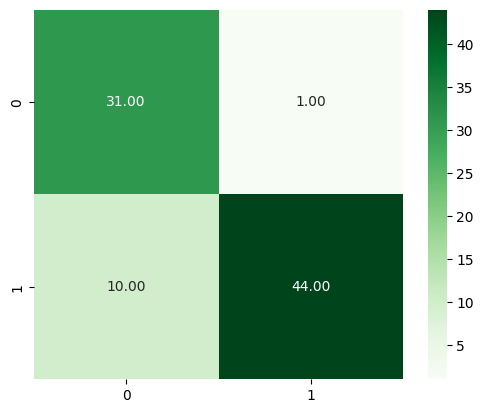

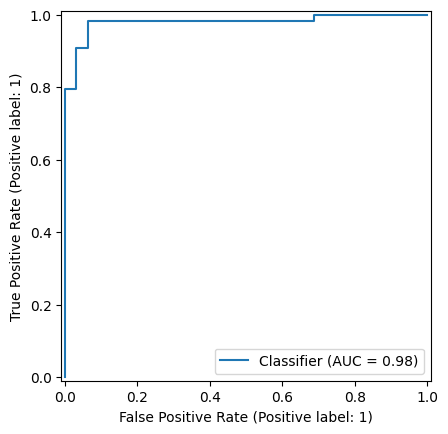

In [80]:
# Metrics for the test --> RF ( Thresholded probability )
cm = confusion_matrix(Y_test, predictions_RF)
acc = accuracy_score(Y_test, predictions_RF)
pc = precision_score(Y_test, predictions_RF)
f1 = f1_score(Y_test, predictions_RF)
AUC = roc_auc_score(Y_test, proba_RF)
sen = recall_score(Y_test, predictions_RF)
TN = cm[0,0]
FP = cm[0,1]
spec = TN/(TN+FP)
print(F'spec: {spec}')
print(f'acc: {acc}')
print(f'pc : {pc}')
print(f'f1 : {f1}')
print(f'AUC: {AUC}')
print(f'sen: {sen}')
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm_df, square=True, cmap='Greens', annot=True, fmt='.2f')
ROC = RocCurveDisplay.from_predictions(Y_test, proba_RF)

# 🏆 Final Model Benchmark & Selection

We evaluated 8 machine learning models on the held-out test set. The primary optimization metric was **Recall (Sensitivity)** to minimize fatal False Negatives in cancer diagnosis. **Specificity** was used as the secondary metric to reduce patient anxiety from false alarms.

## 📊 Performance Summary Table (Updated from attached RTF)

| Rank | Model | Accuracy | Recall (Sensitivity) | Specificity | Status |
| :---: | :--- | :---: | :---: | :---: | :---: |
| 🥇 | **SVC** | **95.3%** | **98.1%** | 90.6% | 🏆 **Winner** |
| 🥈 | KNN | 95.3% | 96.3% | 93.8% | Runner-up |
| 3 | Logistic Regression (LR) | 95.3% | 94.4% | 96.9% | - |
| 4 | Decision Tree (DT) | 91.9% | 92.6% | 90.6% | - |
| 4 | Naive Bayes (NB) | 93.0% | 92.6% | 93.8% | - |
| 6 | XGBoost (XGB) | 91.9% | 88.9% | 96.9% | - |
| 7 | Random Forest (RF) | 87.2% | 81.5% | 96.9% | - |
| 8 | AdaBoost (ADB) | 87.2% | 79.6% | **100.0%** | *High Specificity* |

> Note: Data derived from the attached RTF metrics table. Models are sorted by Recall (Sensitivity).  
> In this iteration, **AdaBoost (ADB)** achieved perfect **Specificity (100.0%)** but performed lowest on **Recall (79.6%)**.

## 🥇 Winning Model: Support Vector Classifier (SVC)

The **Support Vector Classifier (SVC)** is selected as the final production model.

* **Performance:** It achieved the highest **Recall (98.1%)**, effectively minimizing fatal False Negatives. While its **Accuracy (95.3%)** ties with Logistic Regression and KNN, it remains the top choice for the primary safety metric.
* **Impact:** This model prioritizes catching malignant cases. However, it exhibits a trade-off with a lower **Specificity (90.6%)** compared to higher-specificity options like Logistic Regression (96.9%).
* **Configuration:** `kernel='linear'`, `C=10`, `gamma='auto'`, `random_state=42`.
* **Checkpoint:** Saved as `svc_best_model.joblib`.


In [68]:
import joblib

# 1. Select the best estimator found by GridSearchCV
best_model = gs_SVC.best_estimator_

# 2. Save the model to a file
filename = 'svc_best_model.joblib'
joblib.dump(best_model, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to svc_best_model.joblib


# Export model outputs to Excel

This code exports **test-set outputs** from multiple ML models into an existing Excel file (`Breast Cancer.xlsx`) using the same concept as the KNN notebook: **loop through model outputs and write them row-by-row into specific columns**.

---

## ✅ What the code writes into Excel

The Excel sheet will be filled starting from **Column A** with a clean, readable layout:

- **Column A** → `Index` (1, 2, 3, …)
- **Column B** → `True_Label` (from `Y_test`)
- Then **3 columns per model**, in order:
  1) **Probability** of class 1  
  2) **Default logical prediction** (0/1)  
  3) **Threshold-based prediction** using the **train threshold** (`thresh_main*_b`)

---

## 📌 Per-model exported columns

For each model key in:

`["ADB", "LR", "SVC", "RF", "DT", "NB", "KNN", "XGB"]`

the code exports:

1. **`{MODEL}_Prob`**  
   - Uses `proba_{MODEL}` if available (example: `proba_RF`)  
   - Otherwise computes: `model_{MODEL}.predict_proba(X_test)[:, 1]`

2. **`{MODEL}_Pred`**  
   - Uses `prob_{MODEL}_SIMPLE` if available (example: `prob_RF_SIMPLE`)  
   - Otherwise computes: `model_{MODEL}.predict(X_test)`

3. **`{MODEL}_Pred@TrainThr(threshold)`**  
   - Uses the correct **training threshold variable**: `thresh_main{MODEL}_b`  
     (example: `thresh_mainRF_b`)
   - Applies:  
     `pred_thr = (proba_{MODEL} >= thresh_main{MODEL}_b).astype(int)`
   - If `thresh_main{MODEL}_b` is missing, the code falls back to **0.5** and prints a warning.

---

## 🧾 Excel layout example

| Columns | Content |
|--------|---------|
| A | Index |
| B | True_Label |
| C–E | ADB_Prob, ADB_Pred, ADB_Pred@TrainThr |
| F–H | LR_Prob, LR_Pred, LR_Pred@TrainThr |
| I–K | SVC_Prob, SVC_Pred, SVC_Pred@TrainThr |
| ... | ... |
| (3 cols per model) | Prob / Pred / Pred@TrainThr |

The header row (row 1) is bold and centered, and the sheet is frozen at `A2` so the header stays visible while scrolling.

---

## ✅ Required notebook variables

Before running the export cell, you must have:

- `X_test` → test features  
- `Y_test` → test labels  

For each model, the code will use your existing variables if they exist:

- `proba_{MODEL}` (e.g., `proba_RF`)
- `prob_{MODEL}_SIMPLE` (e.g., `prob_RF_SIMPLE`)
- `thresh_main{MODEL}_b` (e.g., `thresh_mainRF_b`)

If `proba_{MODEL}` or `prob_{MODEL}_SIMPLE` is missing, it falls back to:

- `model_{MODEL}.predict_proba(X_test)[:, 1]`
- `model_{MODEL}.predict(X_test)`

---

## ⚠️ Length mismatch handling (important)

The exporter uses:

`n_export = min(len(X_test), len(Y_test))`

So if `X_test` and `Y_test` have different lengths, it will:

- print a warning  
- export only the first `n_export` rows  
- avoid `IndexError`

To export all rows cleanly, ensure:

`len(X_test) == len(Y_test)`

---

## 🎨 Formatting applied automatically

- Probability columns show **3 decimals** (`0.000`)
- Prediction columns show **integer** format (`0`)
- Column widths are adjusted for readability
- Header row is bold + centered
- Freeze panes at `A2`

---

## 🛠 Customization

### Export fewer models
```python
model_keys = ["RF", "KNN", "XGB"]


In [75]:
# ==========================================
# Export to Excel (from column A, with headers)
# For EACH model: proba_*  | prob_*_SIMPLE | Pred@TrainThr (using thresh_main*_b)
# ==========================================

import numpy as np
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment
from openpyxl.utils import get_column_letter

# Path to your Excel file
path = r"C:\Users\Admin\Downloads\Breast Cancer.xlsx"

# You confirmed these exact names exist in your notebook
X_test = X_test
Y_test = Y_test

def safe_float(x):
    try:
        return float(x)
    except Exception:
        return None

def safe_int(x):
    try:
        return int(x)
    except Exception:
        return None

# Edit this list if you have fewer/more models
model_keys = ["ADB", "LR", "SVC", "RF", "DT", "NB", "KNN", "XGB"]

wb = load_workbook(path)
ws = wb.active

# Safe export length
n_export = min(len(X_test), len(Y_test))
if len(X_test) != len(Y_test):
    print(f"⚠️ X_test length={len(X_test)} but Y_test length={len(Y_test)}. Exporting {n_export} rows.")

start_row = 2

# ---- Headers ----
headers = ["Index", "True_Label"]
for k in model_keys:
    thr = globals().get(f"thresh_main{k}_b")
    thr_txt = f"{float(thr):.3f}" if thr is not None else "NA"
    headers += [f"{k}_Prob", f"{k}_Pred", f"{k}_Pred@TrainThr({thr_txt})"]

# Write header row
for c, h in enumerate(headers, start=1):
    cell = ws.cell(row=1, column=c, value=h)
    cell.font = Font(bold=True)
    cell.alignment = Alignment(horizontal="center")

# Write Index and True_Label
for i in range(n_export):
    r = start_row + i
    ws.cell(row=r, column=1, value=i + 1)
    ws.cell(row=r, column=2, value=safe_int(Y_test[i]))

# Write each model block (3 columns per model)
base_col = 3

for mi, k in enumerate(model_keys):
    col_prob = base_col + mi * 3
    col_pred = col_prob + 1
    col_thr  = col_prob + 2

    # --- pull your existing variables ---
    proba = globals().get(f"proba_{k}")
    pred_simple = globals().get(f"prob_{k}_SIMPLE")
    thr = globals().get(f"thresh_main{k}_b")  # ✅ this is the correct training threshold naming

    # If any missing, fall back to computing from model
    if proba is None or pred_simple is None:
        model = globals().get(f"model_{k}")
        if model is None:
            print(f"⚠️ {k}: missing proba_{k} or prob_{k}_SIMPLE and model_{k} not found. Skipping.")
            continue
        if proba is None:
            proba = model.predict_proba(X_test)[:, 1]
        if pred_simple is None:
            pred_simple = model.predict(X_test)

    proba = np.asarray(proba).ravel()
    pred_simple = np.asarray(pred_simple).ravel()

    # --- thresholded prediction based on TRAIN threshold (your thresh_main*_b) ---
    if thr is None:
        print(f"⚠️ {k}: thresh_main{k}_b not found. Using 0.5 instead.")
        pred_thr = (proba >= 0.5).astype(int)
    else:
        pred_thr = (proba >= float(thr)).astype(int)

    pred_thr = np.asarray(pred_thr).ravel()

    # Safety length per model
    n_model = min(n_export, len(proba), len(pred_simple), len(pred_thr))
    if n_model != n_export:
        print(f"⚠️ {k}: length mismatch. proba={len(proba)}, pred={len(pred_simple)}. Writing {n_model}/{n_export} rows.")

    for i in range(n_model):
        r = start_row + i
        ws.cell(row=r, column=col_prob, value=safe_float(proba[i]))
        ws.cell(row=r, column=col_pred, value=safe_int(pred_simple[i]))
        ws.cell(row=r, column=col_thr,  value=safe_int(pred_thr[i]))

# Formatting
ws.freeze_panes = "A2"
ws.column_dimensions["A"].width = 8
ws.column_dimensions["B"].width = 12

for c in range(3, 3 + len(model_keys) * 3):
    letter = get_column_letter(c)
    ws.column_dimensions[letter].width = 18
    header = ws.cell(row=1, column=c).value
    fmt = "0.000" if header and header.endswith("_Prob") else "0"
    for r in range(start_row, start_row + n_export):
        ws.cell(row=r, column=c).number_format = fmt

wb.save(path)
print("✅ Excel export completed and saved.")


✅ Excel export completed and saved.


# Export model metrics to a Word-readable file (RTF table)

This script creates a **Word-openable `.rtf` file** containing a clean table of **Sensitivity, Specificity, and Accuracy** for each model.

✅ **No `python-docx` needed**  
✅ Works even when `docx` import is broken  
✅ Output opens in **Microsoft Word** as a real table

---

## ✅ What this code produces

- A file saved at:

  `C:\Users\Admin\Downloads\Breast Cancer.rtf`

- When you open it in Word, you’ll see a table with columns:

| Method | Sen (%) | Spec (%) | Acc (%) |

- Each row corresponds to one model in:

`["ADB", "LR", "SVC", "RF", "DT", "NB", "KNN", "XGB"]`

---

## 📌 Metrics definitions

For each model, the code computes:

- **Sensitivity (Sen)** = TP / (TP + FN)
- **Specificity (Spec)** = TN / (TN + FP)
- **Accuracy (Acc)** = (TP + TN) / (TP + TN + FP + FN)

All values are exported as **percentages (%)** with **one decimal**.

---

## ✅ Required notebook variables

Before running the script, your notebook must already have:

- `Y_test` → true test labels  
- For each model, at least one prediction array:

### Preferred (threshold-based predictions)
- `predictions_{MODEL}`  
  Example: `predictions_RF`

### Fallback (default logical prediction)
- `prob_{MODEL}_SIMPLE`  
  Example: `prob_RF_SIMPLE`

If neither exists for a model, the script prints a warning and skips that model.

---

## 🧠 How predictions are selected (priority order)

For each model key `k`:

1. **Use thresholded predictions** if available:
   - `predictions_k`

2. If not found, **use simple predictions**:
   - `prob_k_SIMPLE`

3. If neither exists:
   - model is skipped with a warning:
     `⚠️ RF: missing predictions_RF and prob_RF_SIMPLE. Skipping.`

---

## ⚠️ Length mismatch handling

If a prediction array has a different length from `Y_test`, the script:

- prints a warning like:
  `⚠️ RF: length mismatch Y_test=48 vs pred=86. Using n=48.`
- evaluates only the overlapping part:
  `n = min(len(Y_test), len(y_pred))`

This prevents indexing errors and guarantees the export completes.

---

## 🧾 How the RTF table is built

The script manually writes RTF markup that Word understands:

- Defines font (Calibri)
- Writes a title line: **"Breast Cancer Metrics"**
- Builds a 4-column table using `\trowd` and `\cellx...` boundaries
- Escapes special characters (`\ { }`) safely
- Writes:
  - one bold header row
  - one row per model with computed metrics

RTF is **plain text**, so it’s robust and portable.

---

## 🛠 Customization

### Change output file name or location
```python
out_path = r"C:\Users\Admin\Downloads\Breast Cancer.rtf"


In [76]:
# ==========================================
# Word export WITHOUT python-docx (RTF table)
# Creates an .rtf file that opens in Microsoft Word as a table
# ==========================================

import numpy as np
from sklearn.metrics import confusion_matrix

# Output path (Word opens .rtf perfectly)
out_path = r"C:\Users\Admin\Downloads\Breast Cancer.rtf"

# Your confirmed test labels
Y_test = np.asarray(Y_test).ravel()

# models list
model_keys = ["ADB", "LR", "SVC", "RF", "DT", "NB", "KNN", "XGB"]

def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sen = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
    return sen * 100, spec * 100, acc * 100

def get_preds_for_model(k):
    # Prefer thresholded predictions (your pattern: predictions_RF)
    p = globals().get(f"predictions_{k}")
    if p is None:
        # fallback: simple predictions (your pattern: prob_RF_SIMPLE)
        p = globals().get(f"prob_{k}_SIMPLE")
    if p is None:
        return None
    return np.asarray(p).ravel()

# Collect rows
rows = []
for k in model_keys:
    y_pred = get_preds_for_model(k)
    if y_pred is None:
        print(f"⚠️ {k}: missing predictions_{k} and prob_{k}_SIMPLE. Skipping.")
        continue

    n = min(len(Y_test), len(y_pred))
    if n != len(Y_test):
        print(f"⚠️ {k}: length mismatch Y_test={len(Y_test)} vs pred={len(y_pred)}. Using n={n}.")

    sen, spec, acc = compute_metrics(Y_test[:n], y_pred[:n])
    rows.append((k, f"{sen:.1f}", f"{spec:.1f}", f"{acc:.1f}"))

# ---- RTF table writer ----
def rtf_escape(text: str) -> str:
    return text.replace("\\", "\\\\").replace("{", "\\{").replace("}", "\\}")

# Column widths (twips): adjust if you want wider/narrower columns
# ~1 inch = 1440 twips
col1, col2, col3, col4 = 2600, 1500, 1500, 1500  # Method wider
c1 = col1
c2 = col1 + col2
c3 = col1 + col2 + col3
c4 = col1 + col2 + col3 + col4

def rtf_table_row(cells):
    # simple 4-column row
    return (
        r"{\trowd\trgaph108\trleft0"
        + fr"\cellx{c1}\cellx{c2}\cellx{c3}\cellx{c4}"
        + "".join([rf"\intbl {rtf_escape(str(x))}\cell" for x in cells])
        + r"\row}"
        + "\n"
    )

rtf = []
rtf.append(r"{\rtf1\ansi\deff0")
rtf.append(r"{\fonttbl{\f0 Calibri;}}")
rtf.append(r"\fs24")  # 12pt
rtf.append(r"\b Breast Cancer Metrics \b0\par")
rtf.append(r"\par")

# Header row (bold)
rtf.append(r"{\b")
rtf.append(rtf_table_row(["Method", "Sen (%)", "Spec (%)", "Acc (%)"]))
rtf.append(r"}")

# Data rows
for row in rows:
    rtf.append(rtf_table_row(list(row)))

rtf.append("}")

with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(rtf))

print(f"✅ RTF table saved (open in Word): {out_path}")


✅ RTF table saved (open in Word): C:\Users\Admin\Downloads\Breast Cancer.rtf
